## Unsupervised Learning trading strategy
Link: https://www.youtube.com/watch?v=9Y3yaoi9rUQ
### <span style='color:red;'> For learning only. Many issues with this strategy, antiquated. yfinance stocks suffer from survirorship bias</span>
- Download/Load SP500 stocks prices data
- Calculate different features and indicators on each stock
- Aggregate on monthly level and filter top 150 most liquid stocks
- Calculate monthly returns for different time-horizons
- Download Fama-French factors and calculate rolling factor betas
- For each month fit a K-means Clustering algorithm to group similar assets based on their features
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- Visualize portfolio returns and compare to SP500 returns

# Packages needed
- pandas,numpy,matplotlib,statsmodels,pandas_datareader,datetime,yfinance,sklearn,PyPortfolioOpt

### 1. Download/Load SP500 stocks prices data

In [83]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

In [84]:
sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500

Symbol              Security             GICS Sector  \
0      MMM                    3M             Industrials   
1      AOS           A. O. Smith             Industrials   
2      ABT                Abbott             Health Care   
3     ABBV                AbbVie             Health Care   
4      ACN             Accenture  Information Technology   
..     ...                   ...                     ...   
498    YUM           Yum! Brands  Consumer Discretionary   
499   ZBRA    Zebra Technologies  Information Technology   
500    ZBH         Zimmer Biomet             Health Care   
501   ZION  Zions Bancorporation              Financials   
502    ZTS                Zoetis             Health Care   

                      GICS Sub-Industry    Headquarters Location  Date added  \
0              Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1                     Building Products     Milwaukee, Wisconsin  2017-07-26   
2                 Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                         Biotechnology  North Chicago, Illinois  2012-12-31   
4        IT Consulting & Other Services          Dublin, Ireland  2011-07-06   
..                                  ...                      ...         ...   
498                         Restaurants     Louisville, Kentucky  1997-10-06   
499  Electronic Equipment & Instruments   Lincolnshire, Illinois  2019-12-23   
500               Health Care Equipment          Warsaw, Indiana  2001-08-07   
501                      Regional Banks     Salt Lake City, Utah  2001-06-22   
502                     Pharmaceuticals   Parsippany, New Jersey  2013-06-21   

         CIK      Founded  
0      66740         1902  
1      91142         1916  
2       1800         1888  
3    1551152  2013 (1888)  
4    1467373         1989  
..       ...          ...  
498  1041061         1997  
499   877212         1969  
500  1136869         1927  
501   109380         1873  
502  1555280         1952  

[503 rows x 8 columns]

In [85]:
sp500['Symbol']=sp500['Symbol'].str.replace('.','-') # need to do some data cleaning for when we get data from yfinance
sp500

Symbol              Security             GICS Sector  \
0      MMM                    3M             Industrials   
1      AOS           A. O. Smith             Industrials   
2      ABT                Abbott             Health Care   
3     ABBV                AbbVie             Health Care   
4      ACN             Accenture  Information Technology   
..     ...                   ...                     ...   
498    YUM           Yum! Brands  Consumer Discretionary   
499   ZBRA    Zebra Technologies  Information Technology   
500    ZBH         Zimmer Biomet             Health Care   
501   ZION  Zions Bancorporation              Financials   
502    ZTS                Zoetis             Health Care   

                      GICS Sub-Industry    Headquarters Location  Date added  \
0              Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1                     Building Products     Milwaukee, Wisconsin  2017-07-26   
2                 Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                         Biotechnology  North Chicago, Illinois  2012-12-31   
4        IT Consulting & Other Services          Dublin, Ireland  2011-07-06   
..                                  ...                      ...         ...   
498                         Restaurants     Louisville, Kentucky  1997-10-06   
499  Electronic Equipment & Instruments   Lincolnshire, Illinois  2019-12-23   
500               Health Care Equipment          Warsaw, Indiana  2001-08-07   
501                      Regional Banks     Salt Lake City, Utah  2001-06-22   
502                     Pharmaceuticals   Parsippany, New Jersey  2013-06-21   

         CIK      Founded  
0      66740         1902  
1      91142         1916  
2       1800         1888  
3    1551152  2013 (1888)  
4    1467373         1989  
..       ...          ...  
498  1041061         1997  
499   877212         1969  
500  1136869         1927  
501   109380         1873  
502  1555280         1952  

[503 rows x 8 columns]

In [86]:
sp500_sym_list=sp500['Symbol'].unique().tolist()
sp500_sym_list.remove('VLTO')

In [87]:
# set dates for stock data pull
end_date='2023-09-27'
start_date=pd.to_datetime(end_date)-pd.DateOffset(365*8) # get 8 years of data
start_date
df=yf.download(tickers=sp500_sym_list,start=start_date,end=end_date)
df

[*********************100%%**********************]  502 of 502 completed


Price        Adj Close                                                 \
Ticker               A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2015-09-29   31.534708  37.361614   24.684572   36.674244         NaN   
2015-09-30   32.086136  37.027863   24.965233   37.799679         NaN   
2015-10-01   31.534708  37.380695   24.802265   38.299873         NaN   
2015-10-02   32.403912  36.837147   24.983337   38.779232         NaN   
2015-10-05   33.030113  38.324738   25.073875   39.376690         NaN   
...                ...        ...         ...         ...         ...   
2023-09-20  112.054176  13.060000  175.035751  150.648331  138.009995   
2023-09-21  109.324303  13.060000  173.479782  150.471802  132.750000   
2023-09-22  110.998093  12.900000  174.337570  149.795120  132.199997   
2023-09-25  111.526138  12.910000  175.624237  151.668274  134.139999   
2023-09-26  110.320610  12.700000  171.514893  150.942551  132.279999   

Price                                                                 ...  \
Ticker            ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                  ...   
2015-09-29  33.644733  24.416668   83.791534   79.830002   45.552605  ...   
2015-09-30  34.258011  24.490000   85.231461   82.220001   47.541584  ...   
2015-10-01  34.717964  24.463333   85.387573   83.750000   46.302685  ...   
2015-10-02  35.246048  24.780001   86.211601   83.989998   46.934757  ...   
2015-10-05  35.254593  24.993334   88.145935   85.839996   48.401211  ...   
...               ...        ...         ...         ...         ...  ...   
2023-09-20  99.248474  81.320000  314.343628  535.780029  175.254242  ...   
2023-09-21  97.912361  80.290001  309.580841  513.880005  173.024734  ...   
2023-09-22  97.140388  80.959999  313.639160  512.900024  174.657043  ...   
2023-09-25  96.467384  81.150002  314.532135  511.600006  174.607285  ...   
2023-09-26  95.240135  81.260002  308.201630  506.299988  171.531769  ...   

Price         Volume                                                         \
Ticker          WYNN      XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                          
2015-09-29   6223400  3361700  13754400  1073500  1344100  6018857  2358906   
2015-09-30   4265300  2722000  18176500  1558100  1708500  7378142  2012723   
2015-10-01   4745600  2875200  14397800  1378600  1498600  4426718  1604019   
2015-10-02  15153700  3299500  18811300  1791800  1451100  7719772  1353626   
2015-10-05  12699700  5369400  18486700  2245000  2376800  5737736  1352081   
...              ...      ...       ...      ...      ...      ...      ...   
2023-09-20   1061300  7670600  11879900  1290100  1752100  1437200  1055900   
2023-09-21   2358400  4904800  14400600  2143400  2044800  1492700  1489200   
2023-09-22   2611300  4904300  13197300  3712600  1699800  1534100  1267300   
2023-09-25   1387800  3617800  11316000  1957800  1702000  1048500   886700   
2023-09-26   1454000  6275500  11805400  1827800  1322400  1500600  3610500   

Price                                 
Ticker        ZBRA     ZION      ZTS  
Date                                  
2015-09-29  895000  2958200  7328400  
2015-09-30  618800  3514200  4954100  
2015-10-01  464900  2795500  4131800  
2015-10-02  341500  3315700  4036800  
2015-10-05  460600  1924800  5467700  
...            ...      ...      ...  
2023-09-20  824900  1847200  1485500  
2023-09-21  676200  3054300  1691800  
2023-09-22  482200  2364000  1281800  
2023-09-25  314500  1370600  1551100  
2023-09-26  355400  1586100  1463200  

[2012 rows x 3012 columns]

In [88]:
df=df.stack() #rearrange dataframe into more suitable format

In [89]:
df.index.names=['date','ticker']

In [90]:
df

Price               Adj Close       Close        High         Low        Open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684572   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.674244   52.790001   54.189999   51.880001   53.099998   
           ABT      33.644733   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.231339   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.048248  176.869995  178.449997  176.270004  176.580002   

Price                   Volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZION      1586100.0  
           ZTS       1463200.0  

[993179 rows x 6 columns]

In [91]:
df.columns=df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684572   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.674244   52.790001   54.189999   51.880001   53.099998   
           ABT      33.644733   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.231339   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.048248  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZION      1586100.0  
           ZTS       1463200.0  

[993179 rows x 6 columns]

### 2. Calculate features and technical indicators for each stock
- Garman-Klass volatility
- RSI (relative strength index)
- Bollinger Bands
- ATR (average true range)
- MACD (moving average convergence divergence)
- Dollar volume

$$Garman-Klass volatility=\frac{(ln(High)-ln(Low))^{2}}{2}-(2ln(2)-1)(ln(AdjClose)-In(Open))^{2}$$

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684572   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.674244   52.790001   54.189999   51.880001   53.099998   
           ABT      33.644733   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.231339   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.048248  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vola        rsi    bb_low  \
date       ticker                                                        
2015-09-29 A         2252400.0          -0.000926        NaN       NaN   
           AAL       7478800.0          -0.000443        NaN       NaN   
           AAPL    293461600.0          -0.005572        NaN       NaN   
           ABBV     12842800.0          -0.051964        NaN       NaN   
           ABT      12287500.0          -0.008803        NaN       NaN   
...                        ...                ...        ...       ...   
2023-09-26 YUM       1500600.0           0.000037  36.057200  4.821521   
           ZBH       3610500.0           0.000161  31.893253  4.749948   
           ZBRA       355400.0           0.000133  29.494977  5.400991   
           ZION      1586100.0           0.000188  46.707767  3.517162   
           ZTS       1463200.0           0.000072  42.623481  5.158939   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      71.028776  
           AAL          NaN       NaN       NaN       NaN     279.420040  
           AAPL         NaN       NaN       NaN       NaN    7243.974059  
           ABBV         NaN       NaN       NaN       NaN     470.999980  
           ABT          NaN       NaN       NaN       NaN     413.409662  
...                     ...       ...       ...       ...            ...  
2023-09-26 YUM     4.851489  4.881456  0.142547 -1.363696     185.213334  
           ZBH     4.789615  4.829283 -0.381708 -0.881067     404.350437  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZION    3.572582  3.628002 -0.161699 -0.164626      52.708226  
           ZTS     5.217753  5.276568  0.651515 -1.188278     257.593797  

[993179 rows x 14 columns]

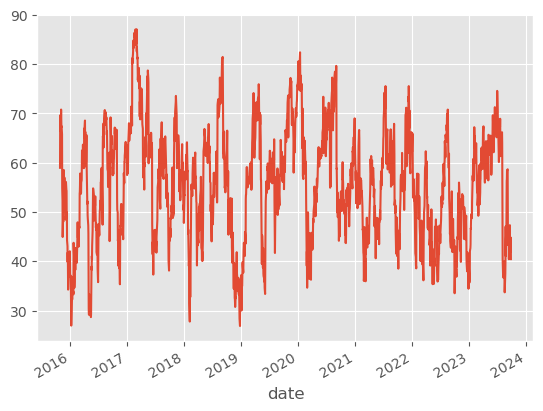

In [92]:
# Garman-Klass
df['garman_klass_vola']=((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# RSI
df['rsi']=df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))
df.xs('AAPL',level=1)['rsi'].plot()

# Bollinger Bands
pandas_ta.bbands(close=df.xs('AAPL',level=1)['adj close'],length=20)
df['bb_low']=df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,0])
df['bb_mid']=df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,1])
df['bb_high']=df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,2])

# ATR 
def compute_art(stock_data):
    atr=pandas_ta.atr(high=stock_data['high'],
                      low=stock_data['low'],
                      close=stock_data['close'],
                      length=14)
    return atr.sub(atr.mean()).div(atr.std()) # normalize the data

df['atr']=df.groupby(level=1,group_keys=False).apply(compute_art) # calulate atr index normalized for each stock. Set group_keys to false so a 2nd date column isn't added

# MACD
def compute_macd(close):
    macd=pandas_ta.macd(close=close,length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd']=df.groupby(level=1,group_keys=False)['adj close'].apply(compute_macd)


# Dollar volume
df['dollar_volume']=(df['adj close']*df['volume'])/1e6 # divide by a million to normalize since millions of trades happen every day


df

### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency

In [93]:
last_cols=[c for c in df.columns.unique(0) if c not in ['dollar_volume','volume','open','high','low','close']]

data=(pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                df.unstack()[last_cols].resample('M').last().stack('ticker')],
                axis=1)).dropna()
data

dollar_volume   adj close  garman_klass_vola        rsi  \
date       ticker                                                            
2015-11-30 A          136.213749   39.086578          -0.001902  73.421486   
           AAL        287.915802   39.429928          -0.000966  40.718981   
           AAPL      4029.441796   26.890556          -0.003209  55.537269   
           ABBV       340.716444   40.770763          -0.056745  49.376847   
           ABT        212.708770   38.483475          -0.010572  56.962486   
...                          ...         ...                ...        ...   
2023-09-30 YUM        176.806022  123.426186           0.000037  36.057200   
           ZBH        192.191763  111.992920           0.000161  31.893253   
           ZBRA       105.780863  223.960007           0.000133  29.494977   
           ZION        99.234720   33.231339           0.000188  46.707767   
           ZTS        288.339376  176.048248           0.000072  42.623481   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.547568  3.620020  3.692471 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.282983  3.326297  3.369611 -0.967900 -0.142790  
           ABBV    3.735768  3.784026  3.832284 -0.526809  0.145677  
           ABT     3.660875  3.682732  3.704588 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 YUM     4.821521  4.851489  4.881456  0.142547 -1.363696  
           ZBH     4.749948  4.789615  4.829283 -0.381708 -0.881067  
           ZBRA    5.400991  5.539167  5.677342 -0.057389 -1.600791  
           ZION    3.517162  3.572582  3.628002 -0.161699 -0.164626  
           ZTS     5.158939  5.217753  5.276568  0.651515 -1.188278  

[46894 rows x 9 columns]

- calculate 5-year rolling average of dollar volume for each stock before filtering.

In [94]:
data['dollar_volume']=(data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12,min_periods=12).mean().stack())
data['dollar_volume_rank']=(data.groupby('date')['dollar_volume'].rank(ascending=False))
data=data[data['dollar_volume_rank']<150].drop(['dollar_volume','dollar_volume_rank'],axis=1) # drop everything but 150 most liquid stocks
data

adj close  garman_klass_vola        rsi    bb_low  \
date       ticker                                                       
2016-10-31 AAL      39.134331          -0.000176  62.203546  3.604673   
           AAPL     26.248026          -0.002384  49.891055  3.295542   
           ABBV     40.620972          -0.044217  27.477851  3.762524   
           ABT      34.463531          -0.006968  38.008810  3.559438   
           ACN     103.970650          -0.004320  53.823681  4.641169   
...                       ...                ...        ...       ...   
2023-09-30 VRTX    351.690002           0.000037  52.406728  5.838959   
           VZ       31.764891          -0.000408  42.222486  3.483152   
           WFC      40.009789           0.000016  40.920287  3.702645   
           WMT     161.898697           0.000011  54.722511  5.077929   
           XOM     114.292953           0.000026  59.440178  4.695106   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655493  3.706314  0.402199  1.131596  
           AAPL    3.324423  3.353305 -1.038688 -0.195978  
           ABBV    3.816700  3.870876 -0.893132 -0.760594  
           ABT     3.609919  3.660400 -1.035224 -0.650889  
           ACN     4.652807  4.664445 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 VRTX    5.859127  5.879295  0.029799  0.027907  
           VZ      3.515375  3.547598 -1.078816 -0.350385  
           WFC     3.743015  3.783384 -0.558742 -0.282325  
           WMT     5.095615  5.113302 -0.196379  0.399459  
           XOM     4.735205  4.775304  0.601335  1.400623  

[12516 rows x 8 columns]

### 4. Calculate monthly returns for different time horizons as features
- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag) (percent change over a give time period), that is, returns over various monthly periods identified as lags

In [95]:
def calculate_returns(df):
    outlier_cutoff=0.005 # trim outliers
    lags=[1,2,3,6,9,12] # month lags

    for lag in lags:
        df[f'return_{lag}m']=(df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)).add(1).pow(1/lag).sub(1)))
        
    return df
data=data.groupby(level=1,group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vola        rsi    bb_low  \
date       ticker                                                       
2017-10-31 AAL      45.534164          -0.000363  41.051766  3.849110   
           AAPL     39.767765          -0.000998  69.196738  3.596048   
           ABBV     68.121437          -0.031904  55.247824  4.205859   
           ABT      48.733868          -0.004755  53.844837  3.897414   
           ACN     129.900711          -0.003628  69.365142  4.806508   
...                       ...                ...        ...       ...   
2023-09-30 VRTX    351.690002           0.000037  52.406728  5.838959   
           VZ       31.764891          -0.000408  42.222486  3.483152   
           WFC      40.009789           0.000016  40.920287  3.702645   
           WMT     161.898697           0.000011  54.722511  5.077929   
           XOM     114.292953           0.000026  59.440178  4.695106   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.642922  3.689797 -0.906642 -0.039275   0.096808   
           ABBV    4.252226  4.298592  0.375557  0.473814   0.022728   
           ABT     3.920986  3.944558 -1.040044  0.276132   0.021275   
           ACN     4.846188  4.885869 -0.986514  0.352341   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 VRTX    5.859127  5.879295  0.029799  0.027907   0.009617   
           VZ      3.515375  3.547598 -1.078816 -0.350385  -0.056890   
           WFC     3.743015  3.783384 -0.558742 -0.282325  -0.015500   
           WMT     5.095615  5.113302 -0.196379  0.399459  -0.000676   
           XOM     4.735205  4.775304  0.601335  1.400623   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[10335 rows x 14 columns]

### 5. Downlaod Fama-French factors and Calculate rolling factor betas
- We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression
- The fice Fama-French factors, namely market risk, size, value, operating profitibility, and investment, have been shown empirically to explaine asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
- We can access the historical factor returns sign the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regresssion.

In [96]:
factor_data=web.DataReader('F-F_Research_data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF',axis=1)
factor_data.index=factor_data.index.to_timestamp()
factor_data

# need to adjust factor dates to the end of the month rather than the start. Data is also in precentages so need to /100
factor_data=factor_data.resample('M').last().div(100)
factor_data.index.name='date'
factor_data

/tmp/ipykernel_2196/3852661217.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data=web.DataReader('F-F_Research_data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF',axis=1)
/tmp/ipykernel_2196/3852661217.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data=web.DataReader('F-F_Research_data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF',axis=1)


Mkt-RF     SMB     HML     RMW     CMA
date                                              
2010-01-31 -0.0336  0.0034  0.0043 -0.0127  0.0046
2010-02-28  0.0340  0.0151  0.0323 -0.0027  0.0143
2010-03-31  0.0631  0.0185  0.0221 -0.0065  0.0169
2010-04-30  0.0200  0.0498  0.0289  0.0069  0.0172
2010-05-31 -0.0789  0.0004 -0.0244  0.0130 -0.0021
...            ...     ...     ...     ...     ...
2023-08-31 -0.0239 -0.0365 -0.0106  0.0343 -0.0237
2023-09-30 -0.0524 -0.0180  0.0152  0.0186 -0.0083
2023-10-31 -0.0319 -0.0404  0.0019  0.0246 -0.0066
2023-11-30  0.0884 -0.0012  0.0164 -0.0391 -0.0100
2023-12-31  0.0485  0.0732  0.0494 -0.0307  0.0132

[168 rows x 5 columns]

In [97]:
# Join the data frames together
factor_data=factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10335 rows x 6 columns]

- Filter out stocks with less than 10 months of data, as we are going to use rolling window of around 2 years so stocks with not enough data doesn't work

In [98]:
observations=factor_data.groupby(level=1).size()
valid_stocks=observations[observations>=10]
factor_data=factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10300 rows x 6 columns]

- Calculate rolling factor betas

In [99]:
betas=(factor_data.groupby(level=1,group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                                          exog=sm.add_constant(x.drop('return_1m',axis=1)),
                                                                          window=min(24,x.shape[0]),
                                                                          min_nobs=len(x.columns)+1)
                                                                          .fit(params_only=True)
                                                                          .params.drop('const',axis=1)))

In [100]:
# Need to shift the rolling calculations forward 1 month before joining betas into the data table
data=(data.join(betas.groupby('ticker').shift()))
# compute missing values of betas with the average
factors=['Mkt-RF','SMB','HML','RMW','CMA']
data.loc[:,factors]=data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data


adj close  garman_klass_vola        rsi    bb_low  \
date       ticker                                                       
2017-10-31 AAL      45.534164          -0.000363  41.051766  3.849110   
           AAPL     39.767765          -0.000998  69.196738  3.596048   
           ABBV     68.121437          -0.031904  55.247824  4.205859   
           ABT      48.733868          -0.004755  53.844837  3.897414   
           ACN     129.900711          -0.003628  69.365142  4.806508   
...                       ...                ...        ...       ...   
2023-09-30 VRTX    351.690002           0.000037  52.406728  5.838959   
           VZ       31.764891          -0.000408  42.222486  3.483152   
           WFC      40.009789           0.000016  40.920287  3.702645   
           WMT     161.898697           0.000011  54.722511  5.077929   
           XOM     114.292953           0.000026  59.440178  4.695106   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.642922  3.689797 -0.906642 -0.039275   0.096808   
           ABBV    4.252226  4.298592  0.375557  0.473814   0.022728   
           ABT     3.920986  3.944558 -1.040044  0.276132   0.021275   
           ACN     4.846188  4.885869 -0.986514  0.352341   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 VRTX    5.859127  5.879295  0.029799  0.027907   0.009617   
           VZ      3.515375  3.547598 -1.078816 -0.350385  -0.056890   
           WFC     3.743015  3.783384 -0.558742 -0.282325  -0.015500   
           WMT     5.095615  5.113302 -0.196379  0.399459  -0.000676   
           XOM     4.735205  4.775304  0.601335  1.400623   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702   
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228   
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026   
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294   
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728   
...                      ...        ...        ...        ...         ...   
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337   
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158   
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255   
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAL     1.265664  1.314316  0.601340  0.458860  0.563293  
           AAPL    1.275749 -0.271695 -0.591144  0.647781  0.458079  
           ABBV    0.494523  0.362281 -0.033101  0.241981  0.164920  
           ABT     0.828092 -0.199020 -0.529386  0.252409  0.970213  
           ACN     1.199046 -0.166700 -0.328214  0.267791  0.168883  
...                     ...       ...       ...       ...       ...  
2023-09-30 VRTX    0.504915 -0.411099 -0.481425  0.057280  0.943566  
           VZ      0.302531 -0.212074  0.344590  0.318167  0.000826  
           WFC     1.137640  0.314482  2.009074 -0.404338 -1.468839  
           WMT     0.740055 -0.261890 -0.522676 -0.126426  0.642626  
           XOM     1.005968 -1.051369  1.707833 -0.675679 -0.284025  

[10335 rows x 19 columns]

In [101]:
data.dropna()
data=data.drop('adj close',axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10335 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   garman_klass_vola  10335 non-null  float64
 1   rsi                10335 non-null  float64
 2   bb_low             10335 non-null  float64
 3   bb_mid             10335 non-null  float64
 4   bb_high            10335 non-null  float64
 5   atr                10335 non-null  float64
 6   macd               10335 non-null  float64
 7   return_1m          10335 non-null  float64
 8   return_2m          10335 non-null  float64
 9   return_3m          10335 non-null  float64
 10  return_6m          10335 non-null  float64
 11  return_9m          10335 non-null  float64
 12  return_12m         10335 non-null  float64
 13  Mkt-RF             10062 non-null  float64
 14  SMB                10062 non-null  float64

### next step is to use machine learning to determine which stocks to keep in the portfolio every month using a long position

# 6. For each month fit a K-Means Clustering algorithm to group similar assets based on their features

## K-Means Clustering
- You may want to initialize predefined centroids for each cluster based on your research.
- For visualization purpose of this tutorial we will initially rely on the 'k-means++' initilization.
- Then we will pre-define our centroids for each cluster.


In [102]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster']=KMeans(n_clusters=4,
                        random_state=0, # ensure results are the same each run
                        init='random').fit(df).labels_ # initialize Kmeans class, fit it to the data, and get the labels of each point
    return df

data=data.dropna().groupby('date',group_keys=False).apply(get_clusters) # clean data and group by dates


/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` expl

In [103]:
data

garman_klass_vola        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                               
2017-10-31 AAL             -0.000363  41.051766  3.849110  3.921750  3.994389   
           AAPL            -0.000998  69.196738  3.596048  3.642922  3.689797   
           ABBV            -0.031904  55.247824  4.205859  4.252226  4.298592   
           ABT             -0.004755  53.844837  3.897414  3.920986  3.944558   
           ACN             -0.003628  69.365142  4.806508  4.846188  4.885869   
...                              ...        ...       ...       ...       ...   
2023-09-30 VRTX             0.000037  52.406728  5.838959  5.859127  5.879295   
           VZ              -0.000408  42.222486  3.483152  3.515375  3.547598   
           WFC              0.000016  40.920287  3.702645  3.743015  3.783384   
           WMT              0.000011  54.722511  5.077929  5.095615  5.113302   
           XOM              0.000026  59.440178  4.695106  4.735205  4.775304   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039275   0.096808   0.015249   0.044955   
           ABBV    0.375557  0.473814   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276132   0.021275   0.034308   0.034801   
           ACN    -0.986514  0.352341   0.064180   0.048454   0.037202   
...                     ...       ...        ...        ...        ...   
2023-09-30 VRTX    0.029799  0.027907   0.009617  -0.000923  -0.000208   
           VZ     -1.078816 -0.350385  -0.056890  -0.016122  -0.033458   
           WFC    -0.558742 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -0.196379  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494523  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828092 -0.199020   
           ACN      0.028692   0.027398    0.018728  1.199046 -0.166700   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.504915 -0.411099   
           VZ      -0.021495  -0.014100   -0.006158  0.302531 -0.212074   
           WFC      0.016712   0.000702    0.003255  1.137640  0.314482   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051369   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        2  
           AAPL   -0.591144  0.647781  0.458079        1  
           ABBV   -0.033101  0.241981  0.164920        3  
           ABT    -0.529386  0.252409  0.970213        3  
           ACN    -0.328214  0.267791  0.168883        1  
...                     ...       ...       ...      ...  
2023-09-30 VRTX   -0.481425  0.057280  0.943566        2  
           VZ      0.344590  0.318167  0.000826        1  
           WFC     2.009074 -0.404338 -1.468839        3  
           WMT    -0.522676 -0.126426  0.642626        2  
           XOM     1.707833 -0.675679 -0.284025        2  

[10062 rows x 19 columns]

In [104]:
def plot_clusters(data):
    cluster_0=data[data['cluster']==0]
    cluster_1=data[data['cluster']==1]
    cluster_2=data[data['cluster']==2]
    cluster_3=data[data['cluster']==3]

    # we want the atr and the rsi, columns 5 and 1 respectively
    plt.scatter(cluster_0.iloc[:,5],cluster_0.iloc[:,1],color='red',label='cluster_0')
    plt.scatter(cluster_1.iloc[:,5],cluster_1.iloc[:,1],color='green',label='cluster_1')
    plt.scatter(cluster_2.iloc[:,5],cluster_2.iloc[:,1],color='blue',label='cluster_2')
    plt.scatter(cluster_3.iloc[:,5],cluster_3.iloc[:,1],color='black',label='cluster_3')

    plt.legend()
    plt.show()
    return

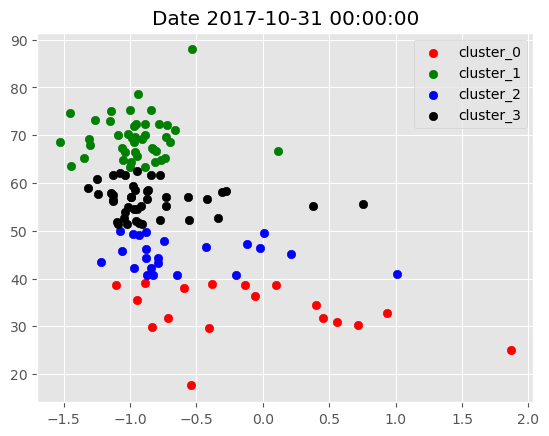

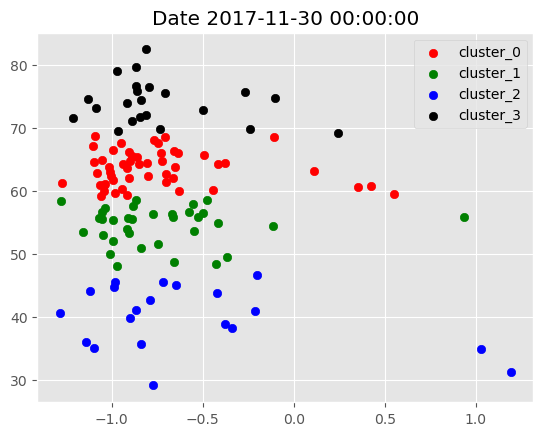

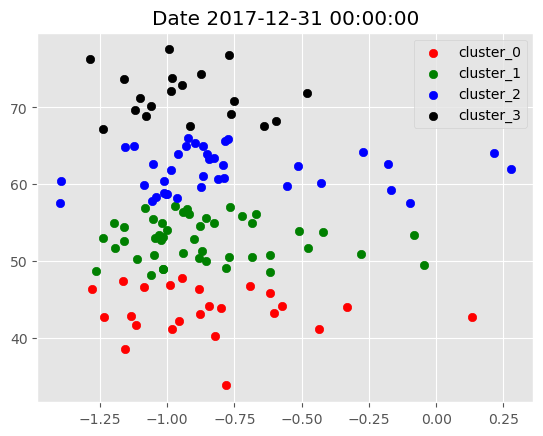

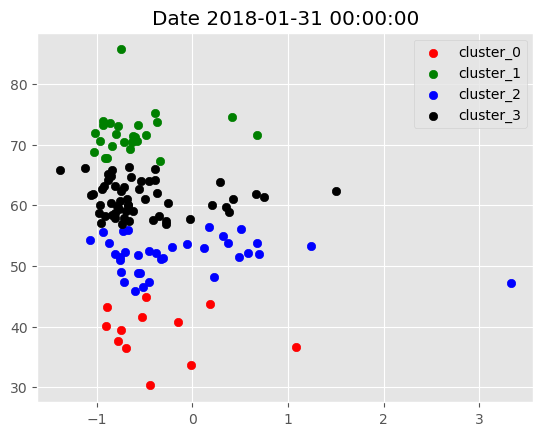

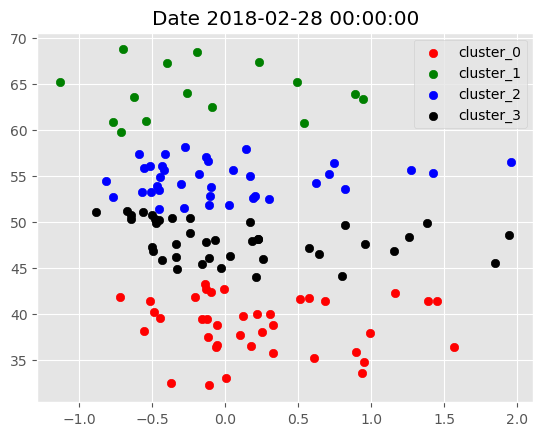

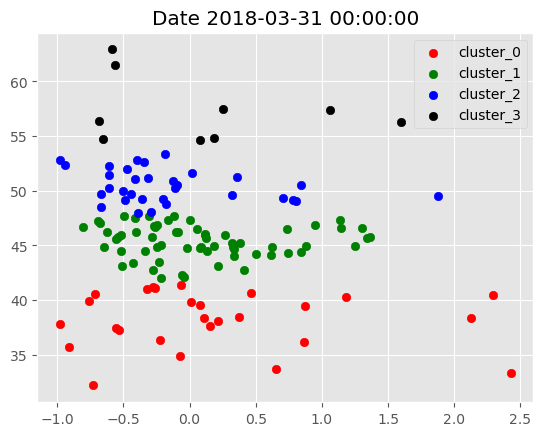

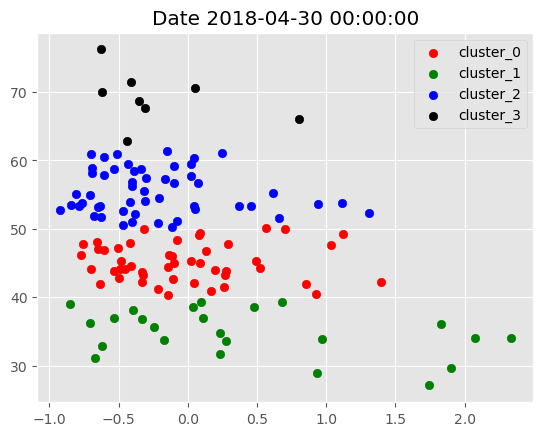

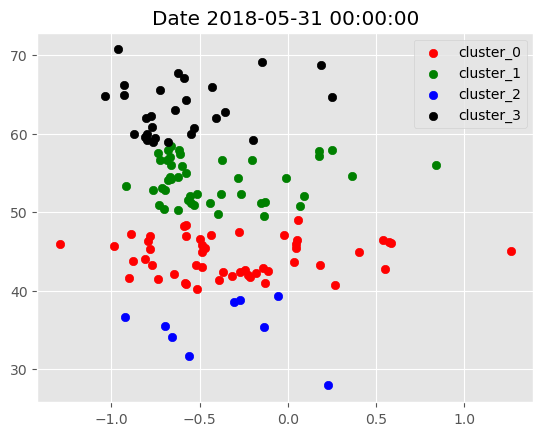

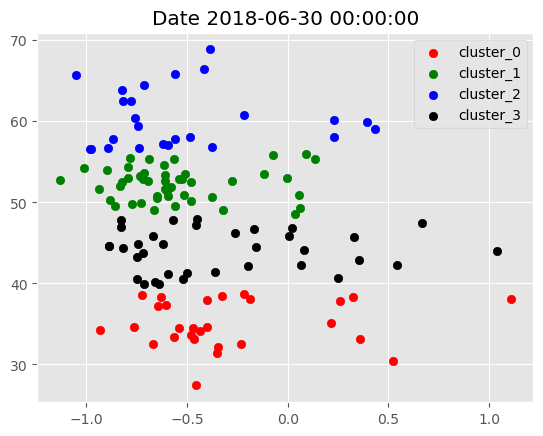

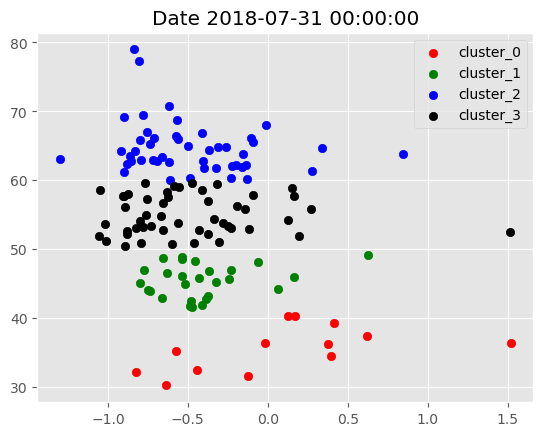

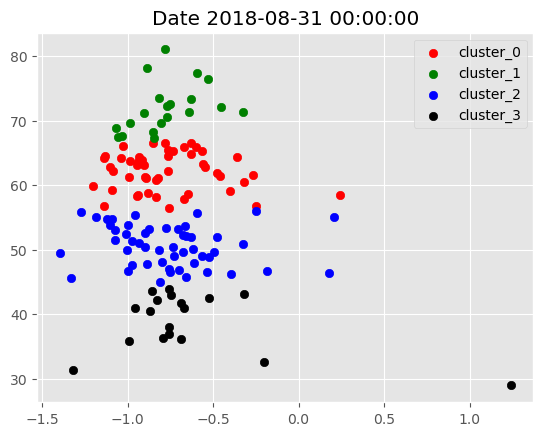

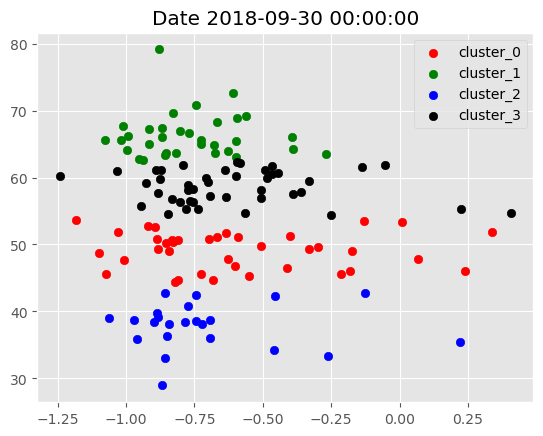

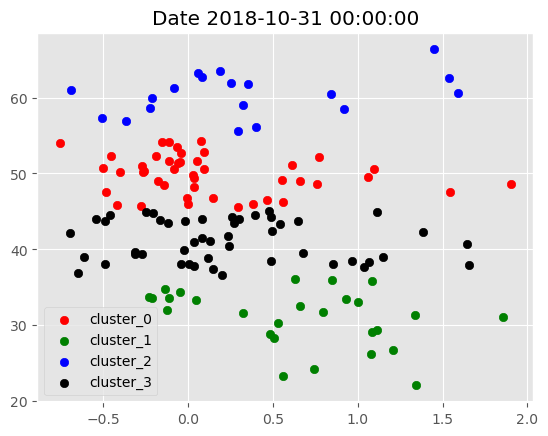

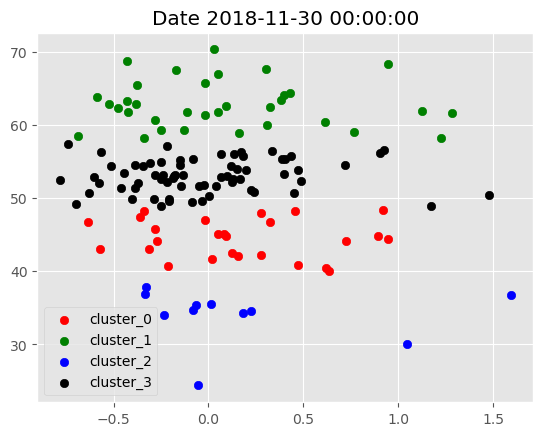

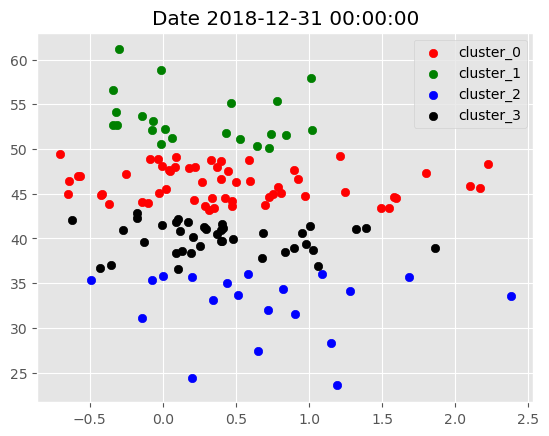

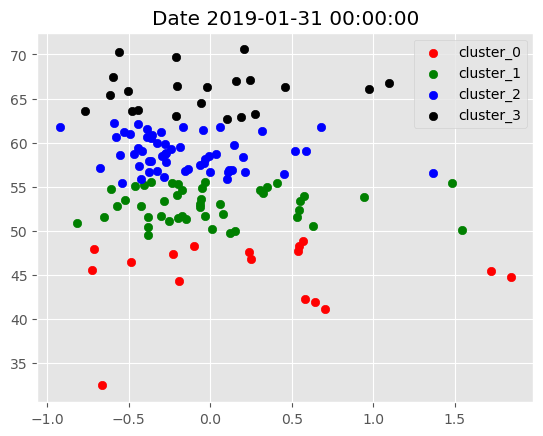

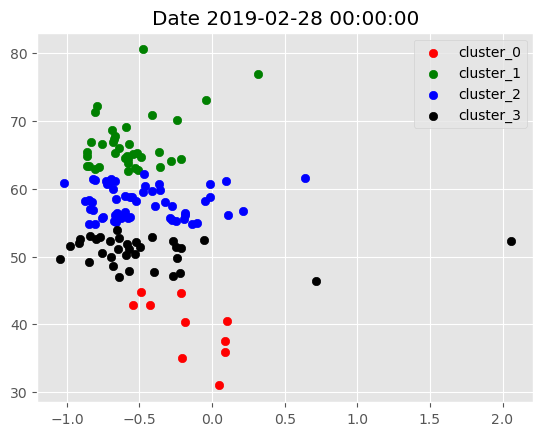

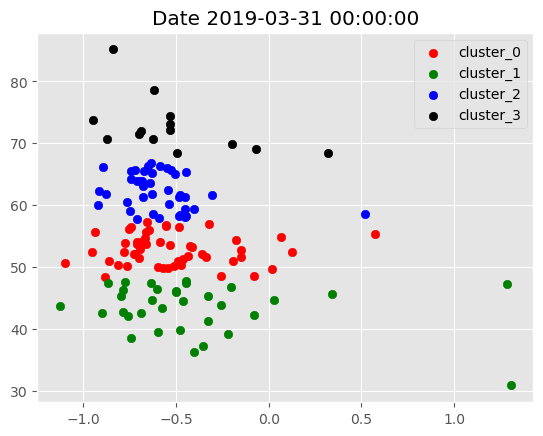

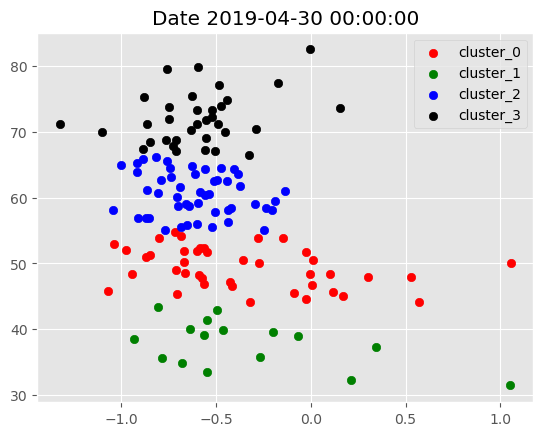

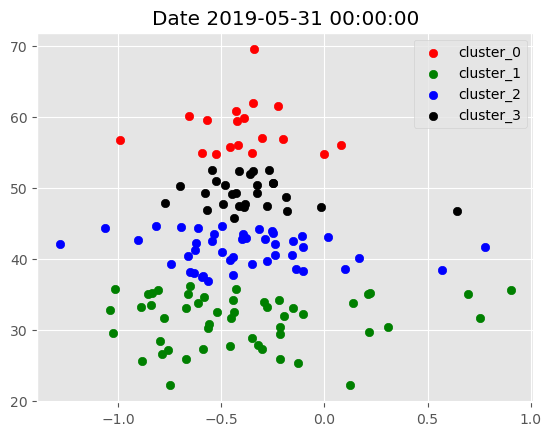

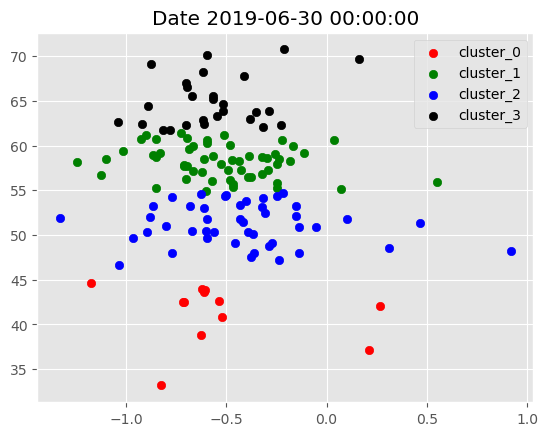

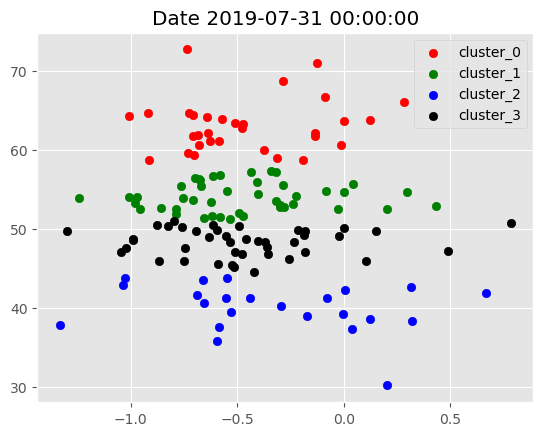

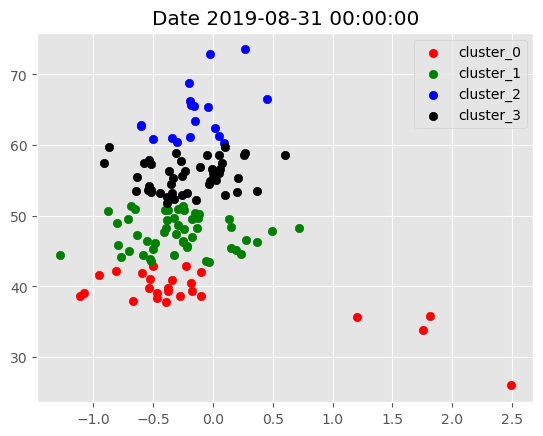

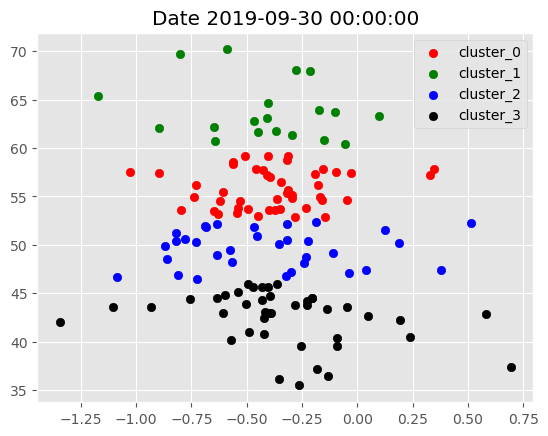

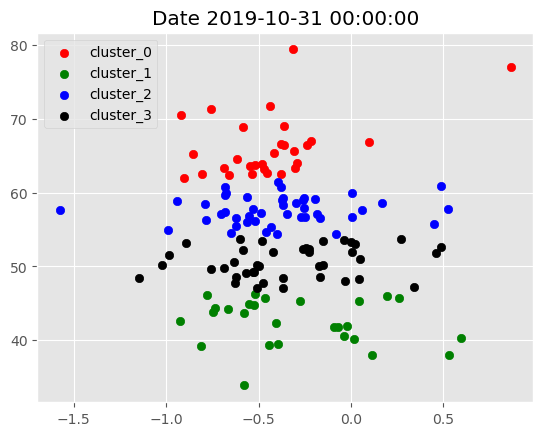

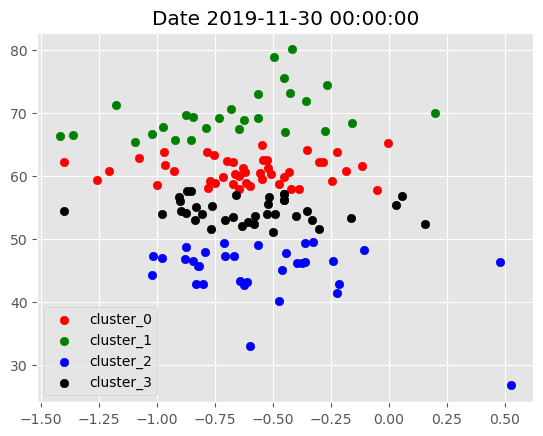

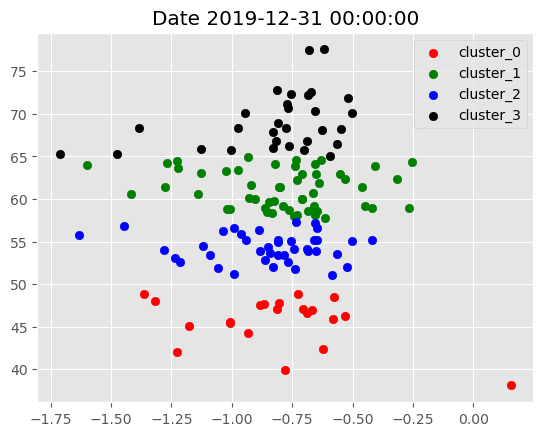

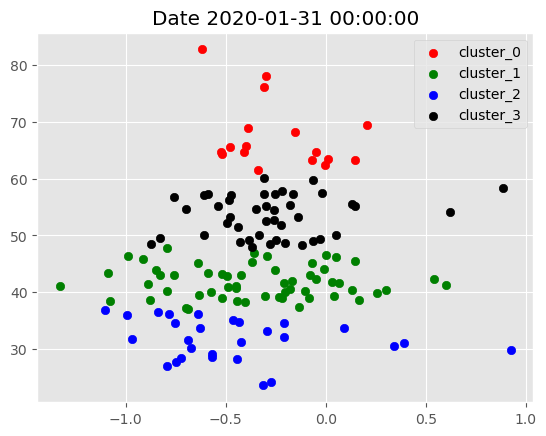

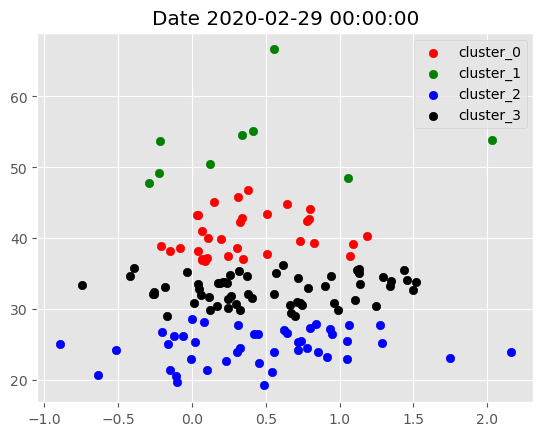

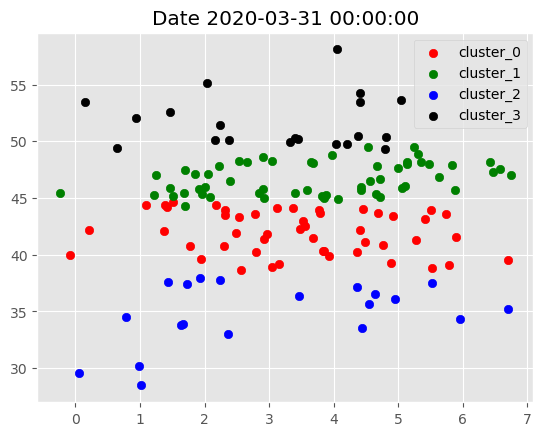

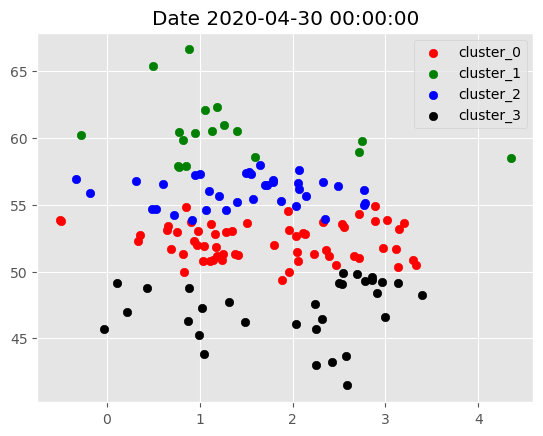

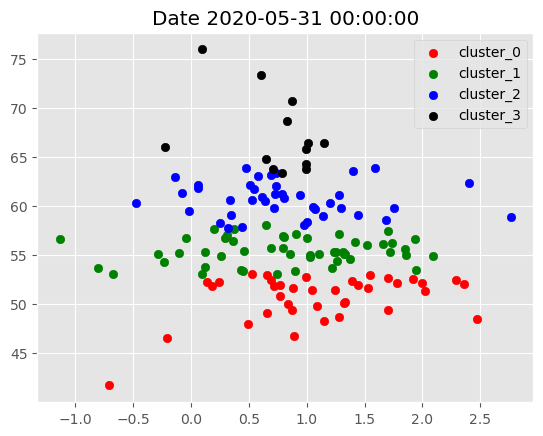

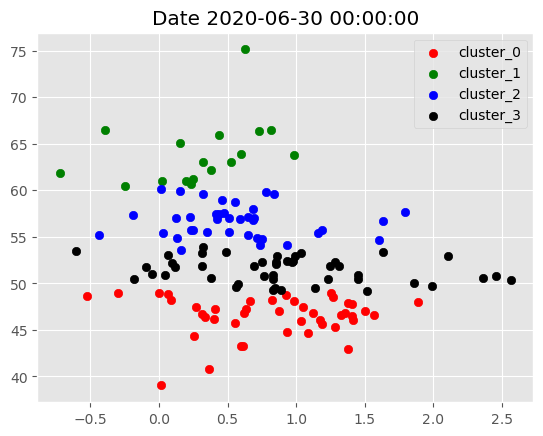

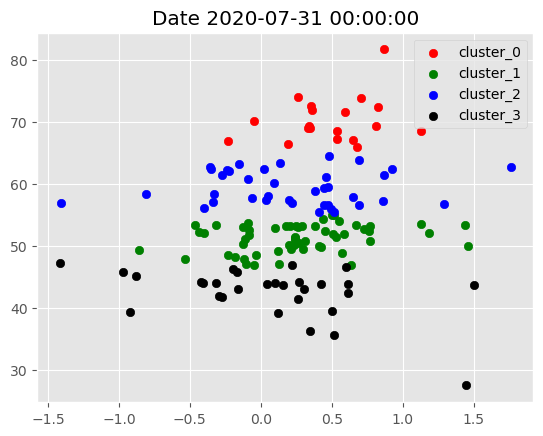

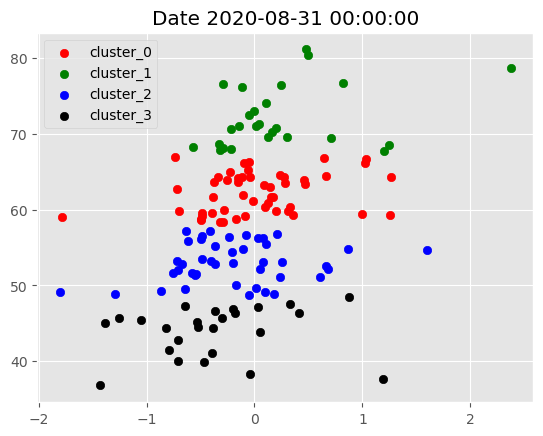

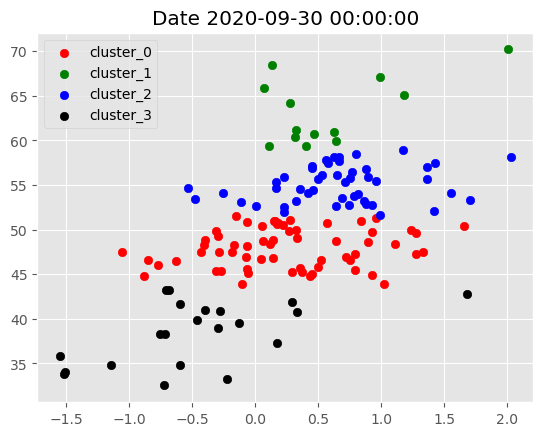

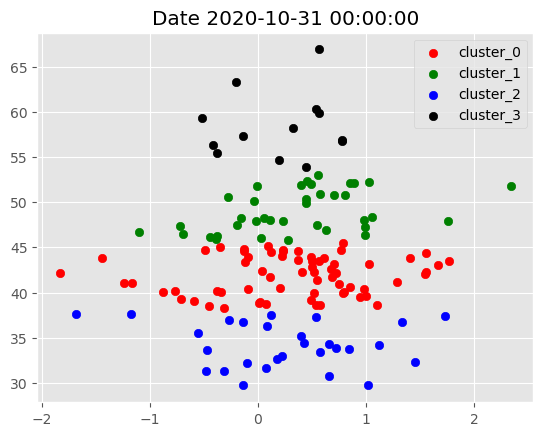

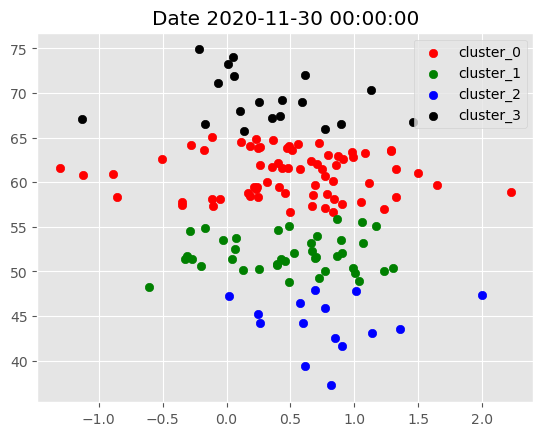

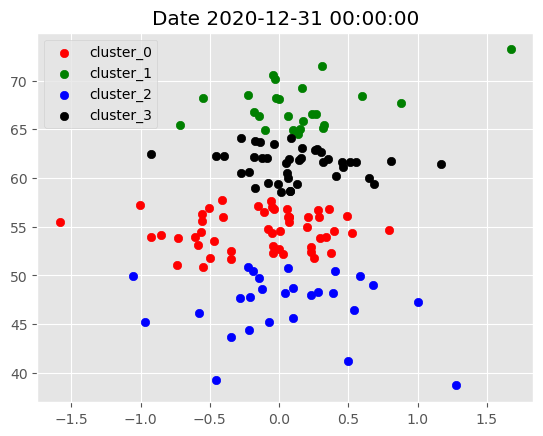

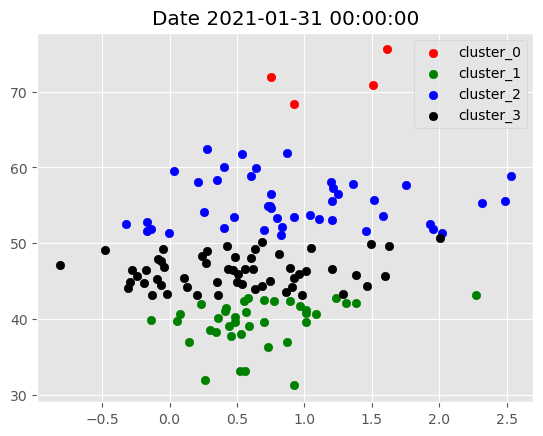

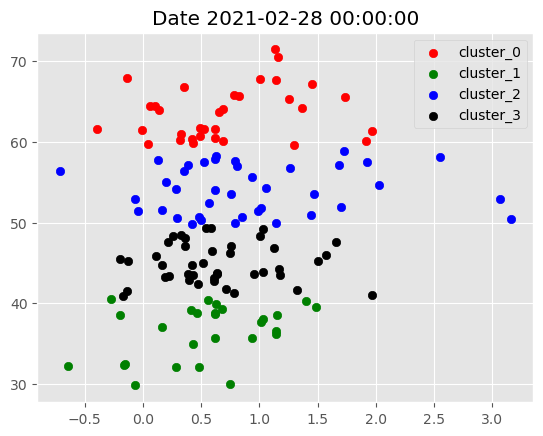

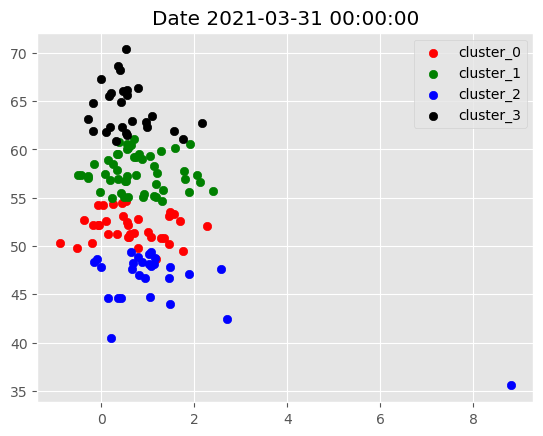

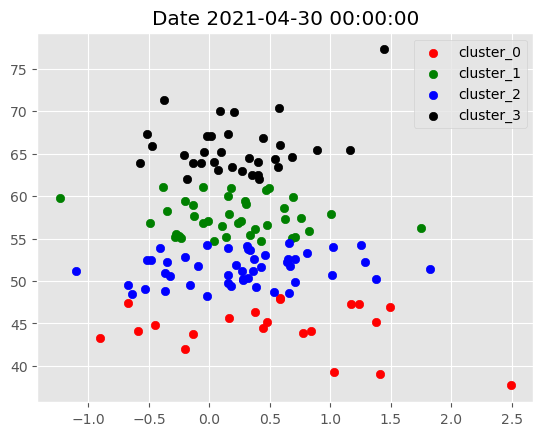

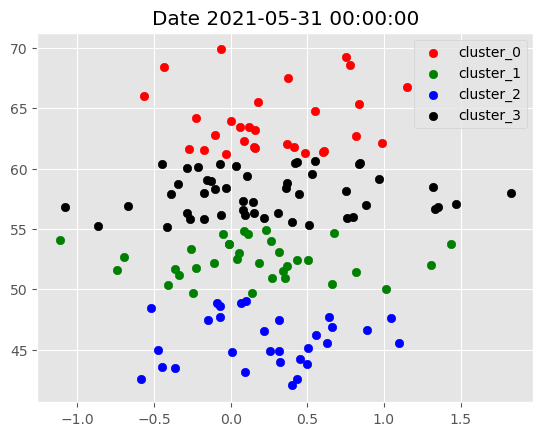

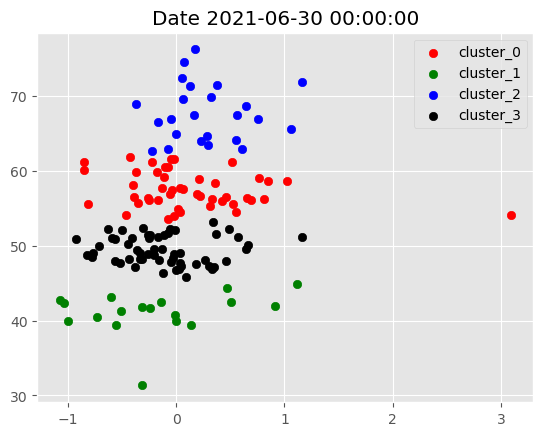

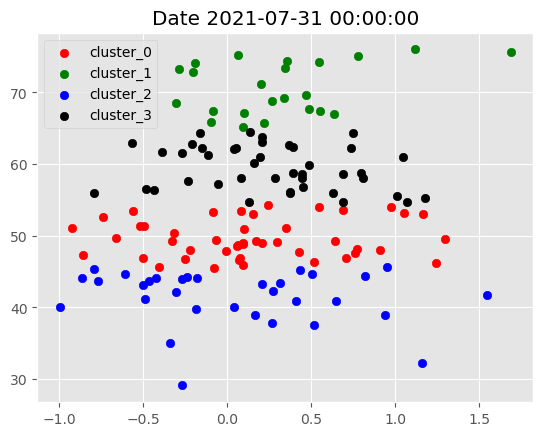

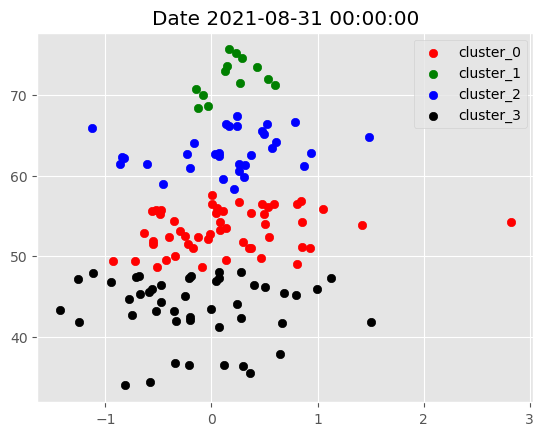

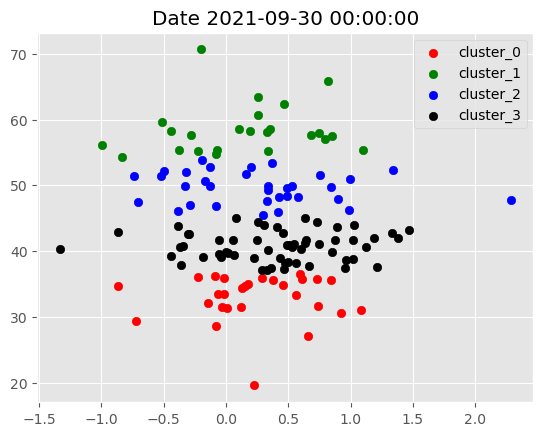

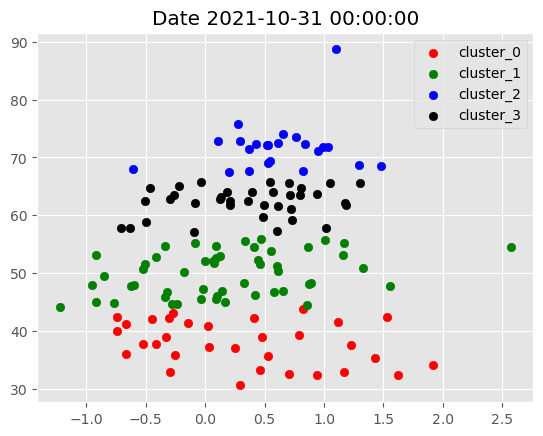

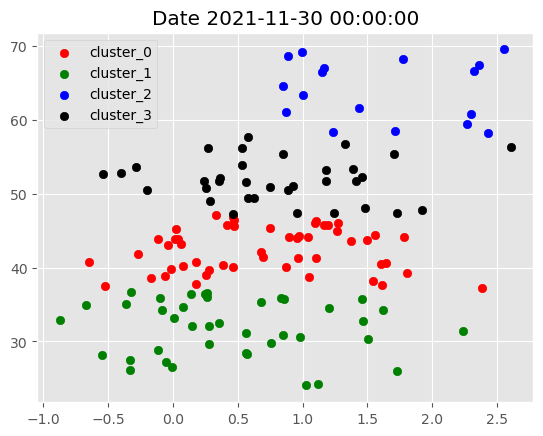

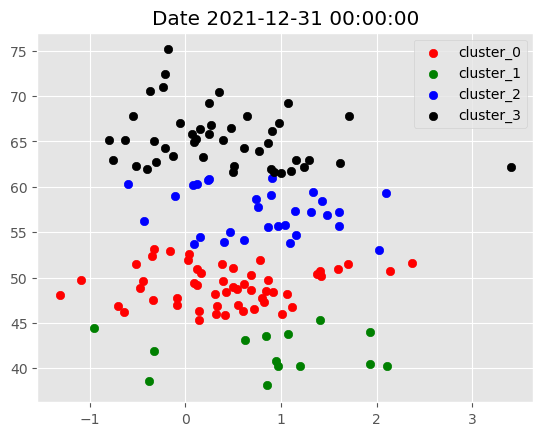

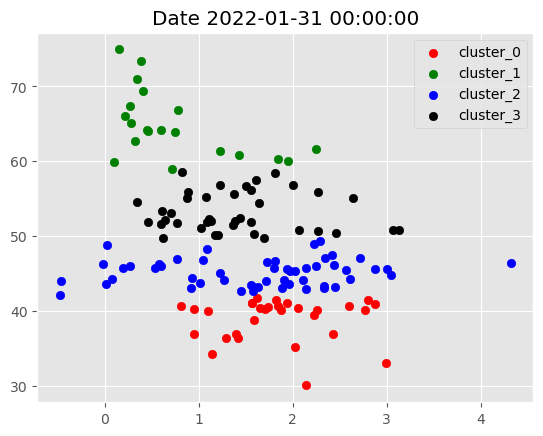

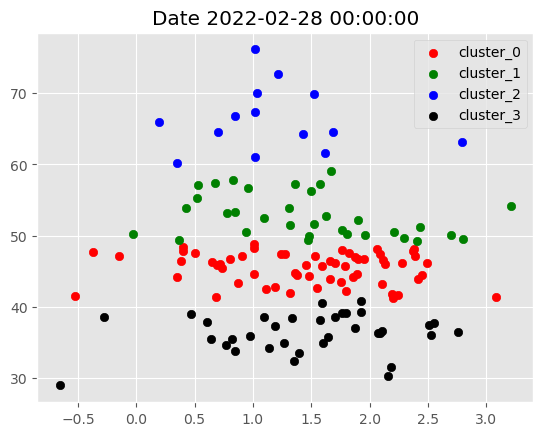

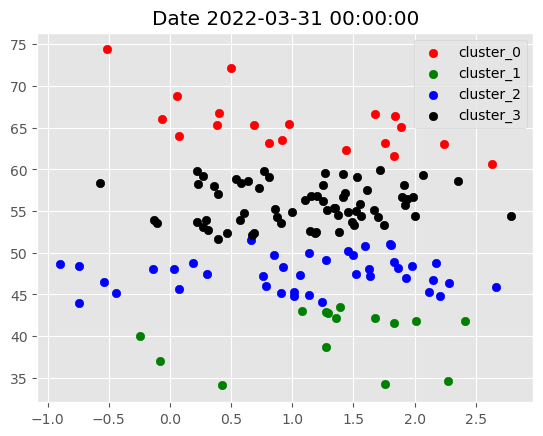

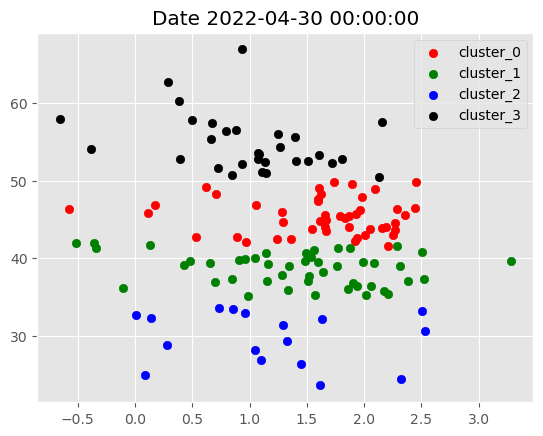

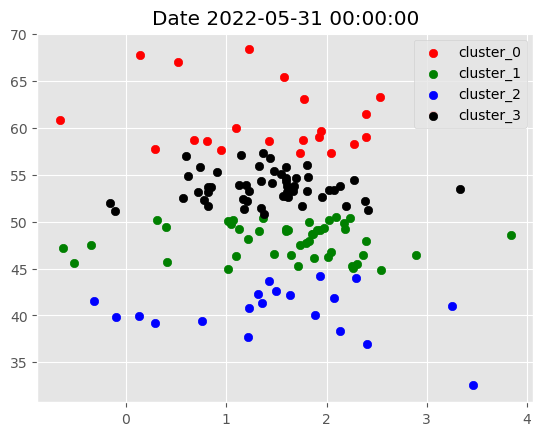

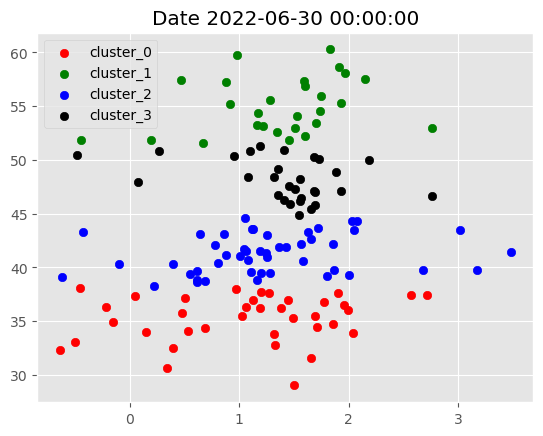

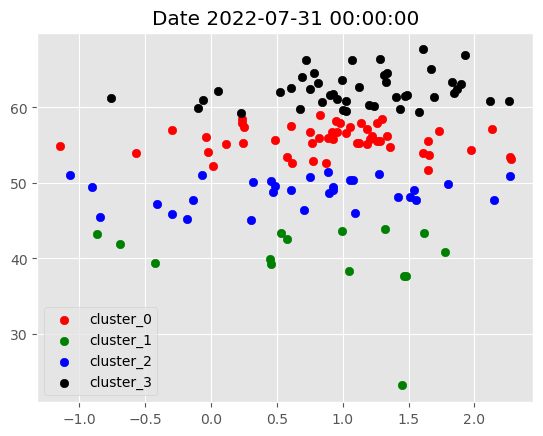

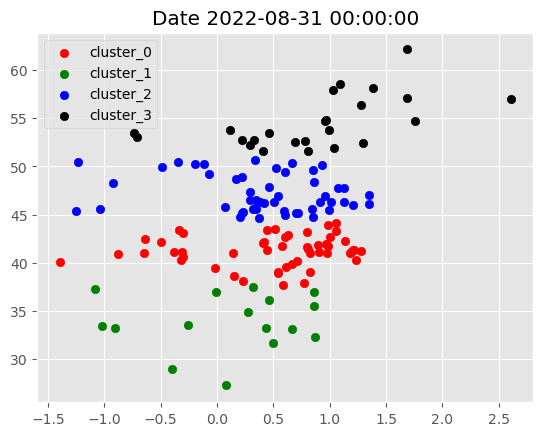

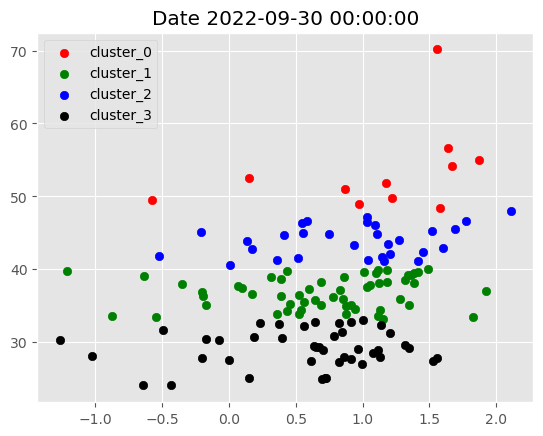

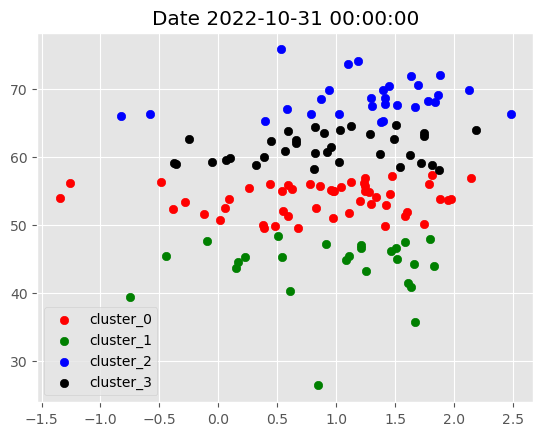

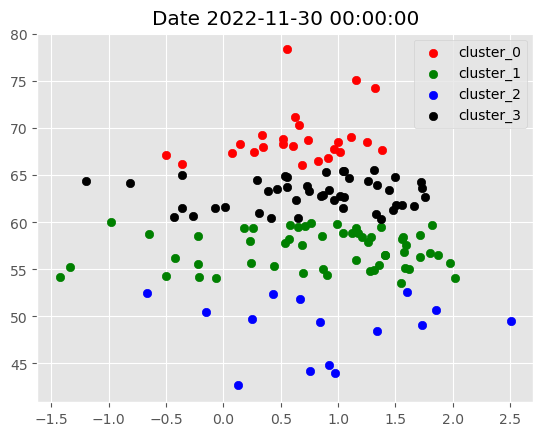

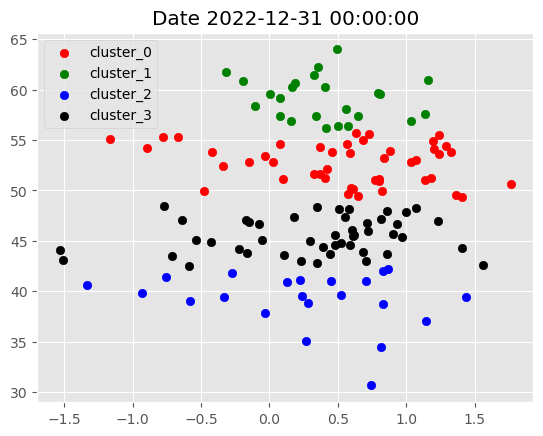

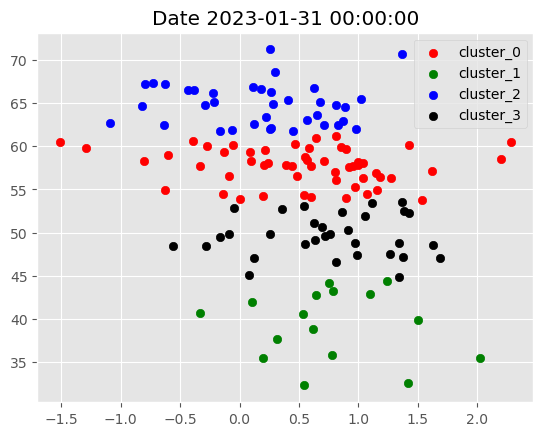

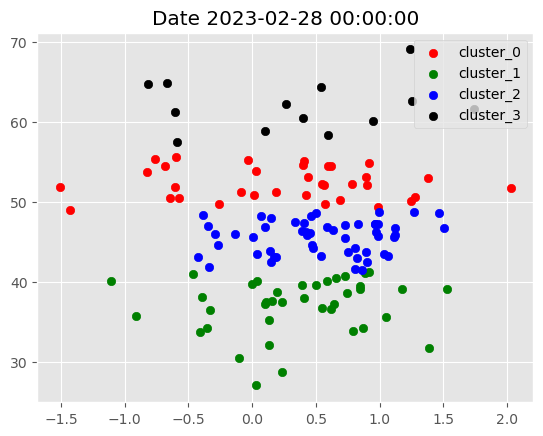

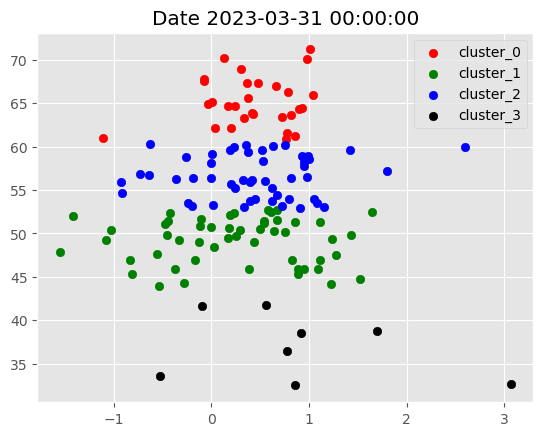

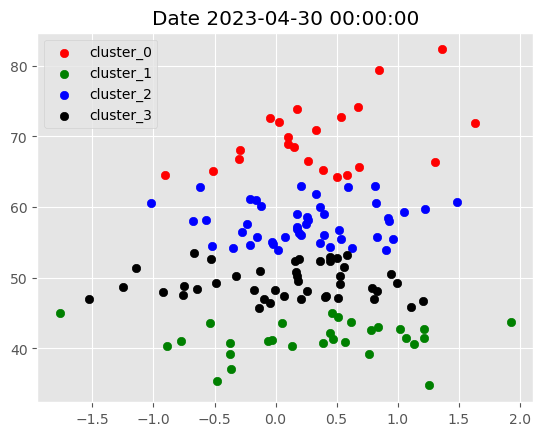

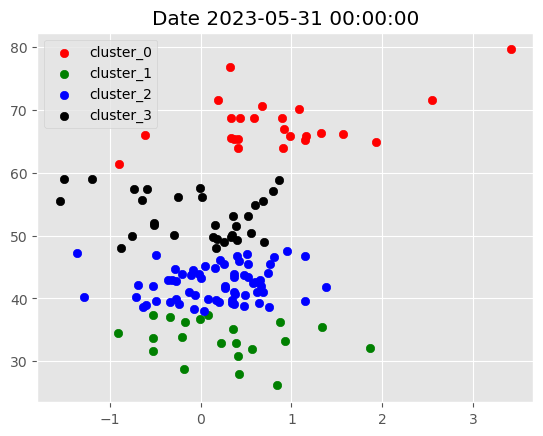

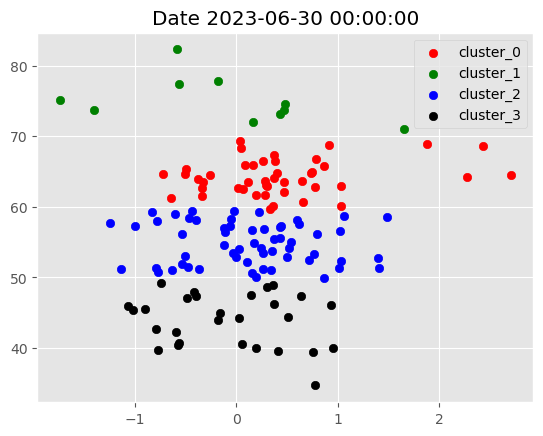

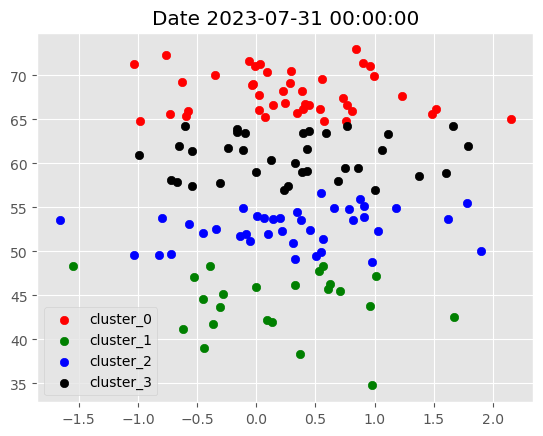

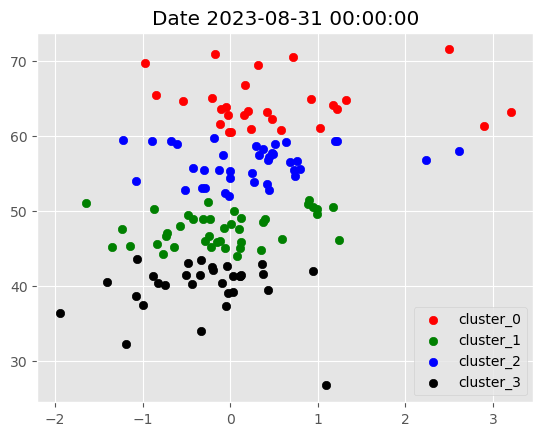

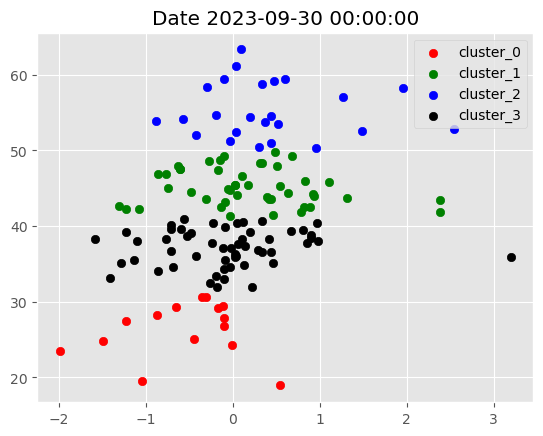

In [105]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g=data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kalgan/miniconda3/envs/wonderland/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of 

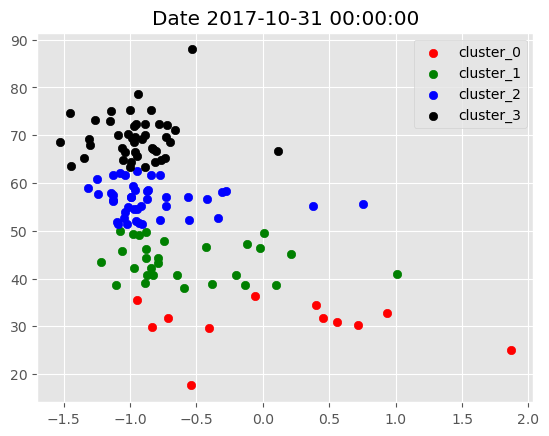

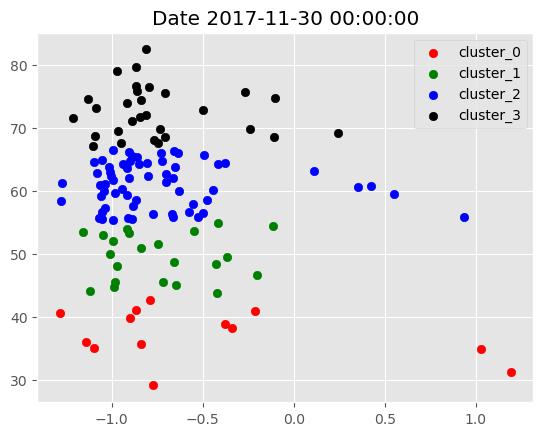

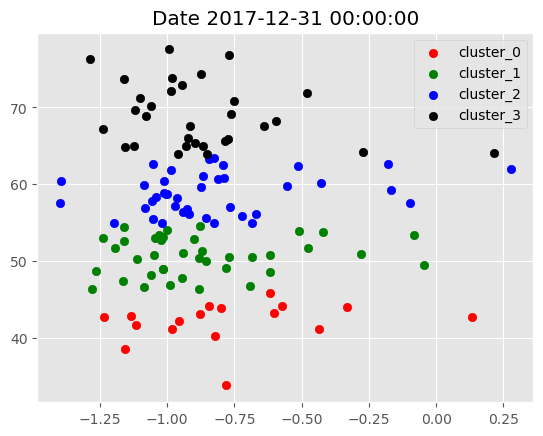

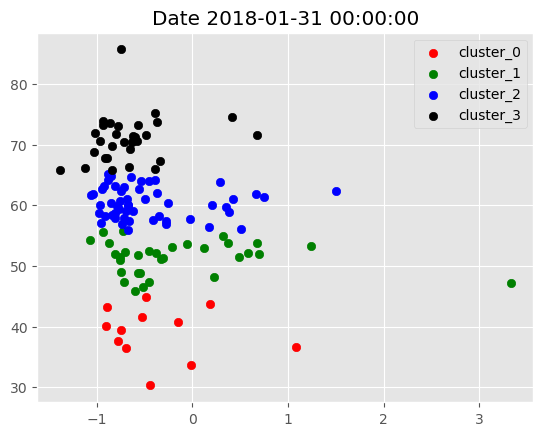

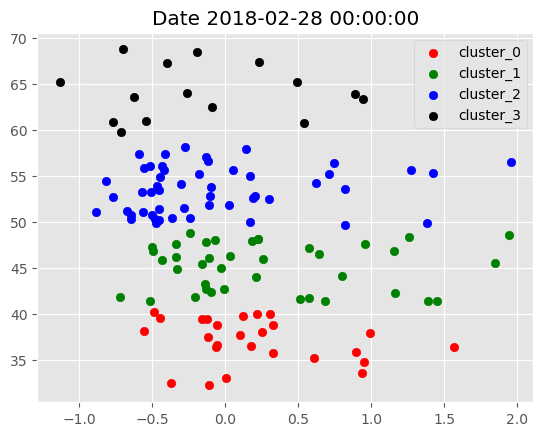

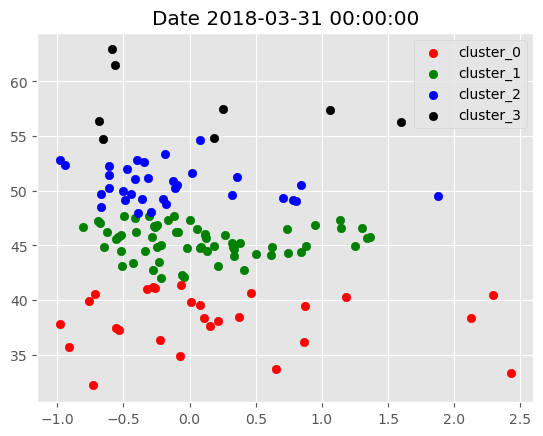

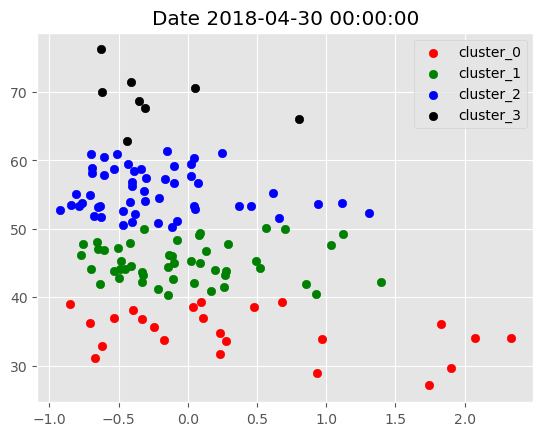

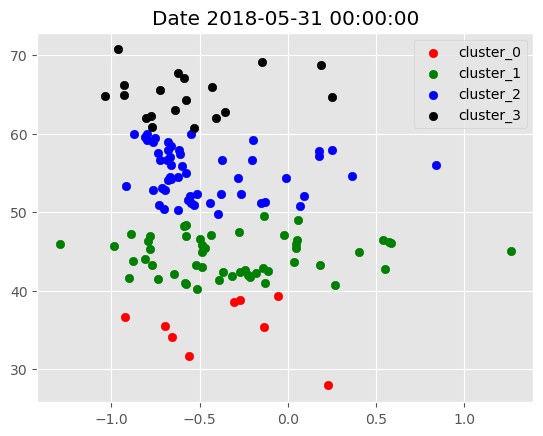

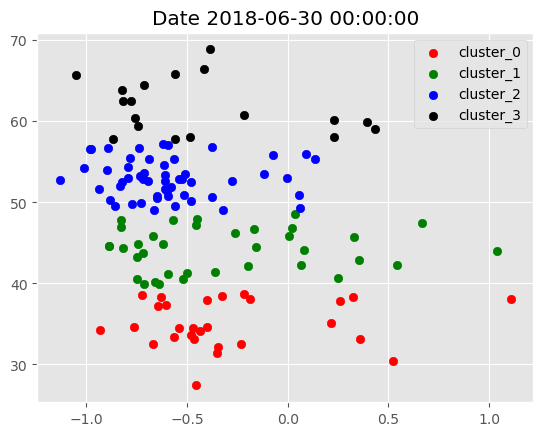

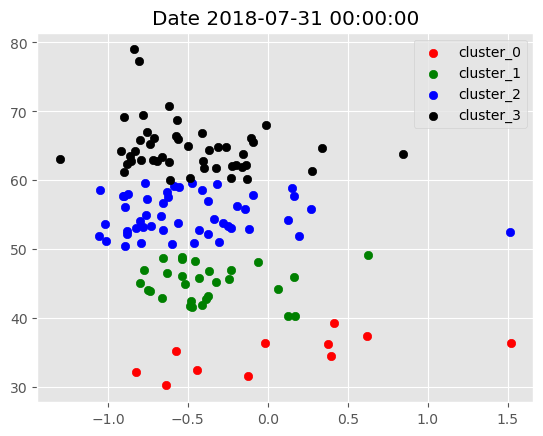

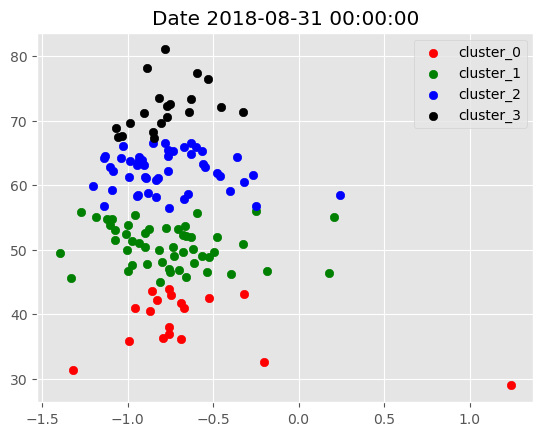

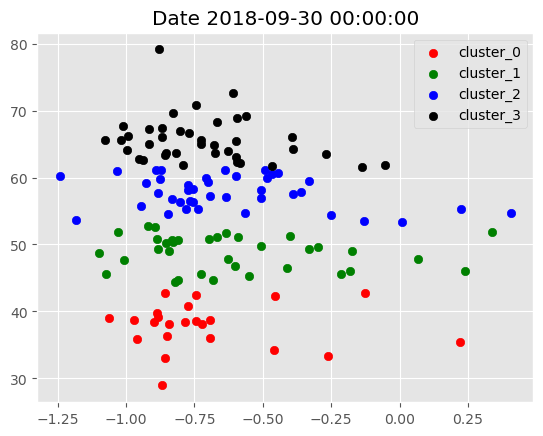

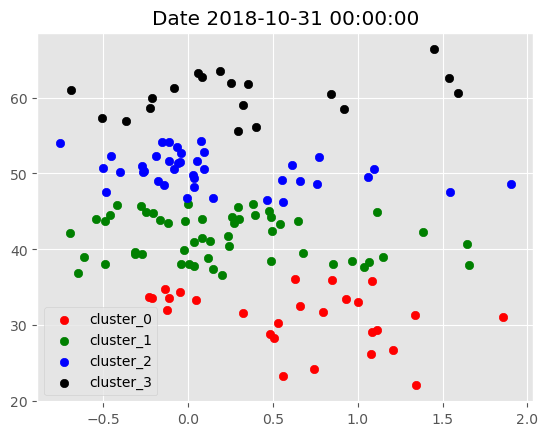

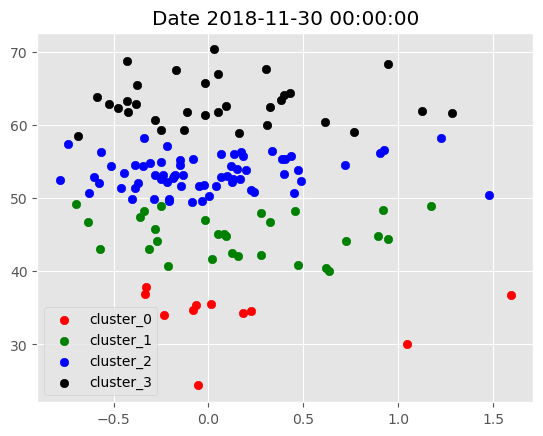

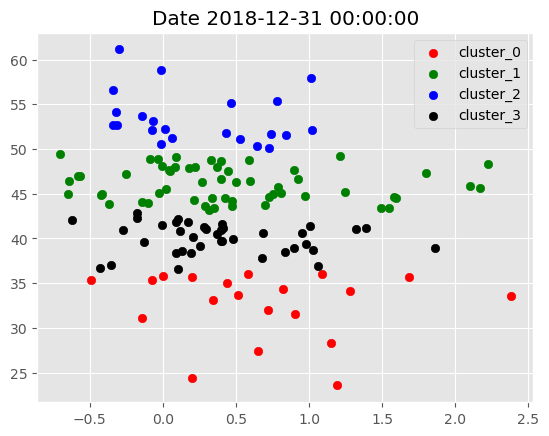

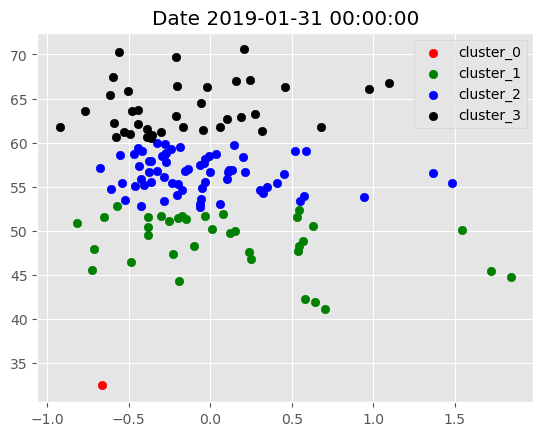

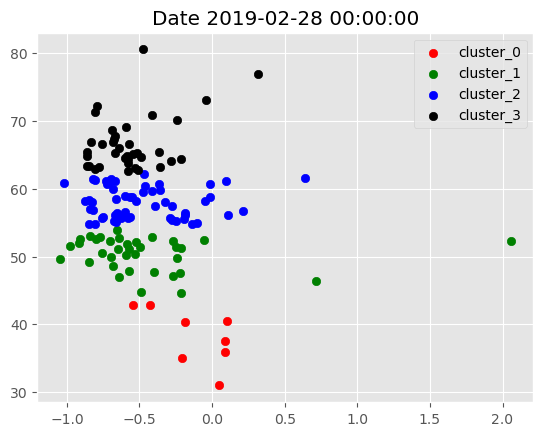

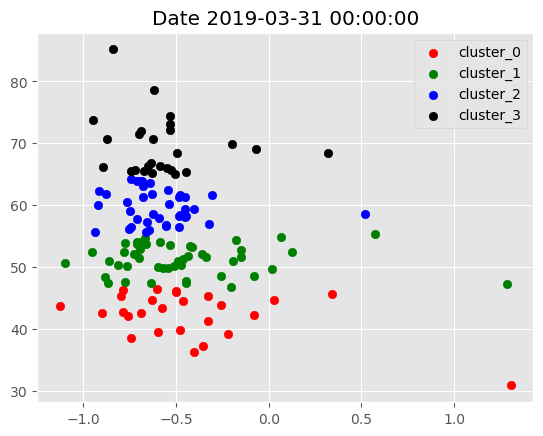

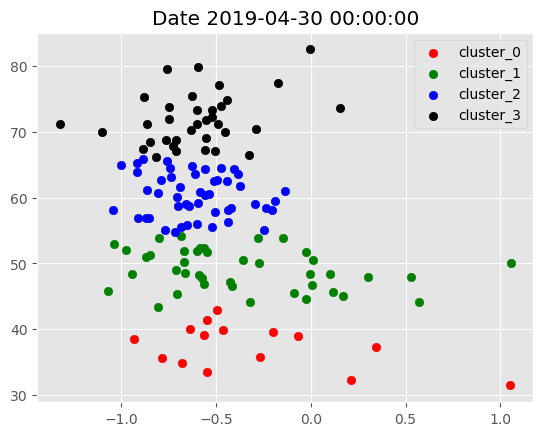

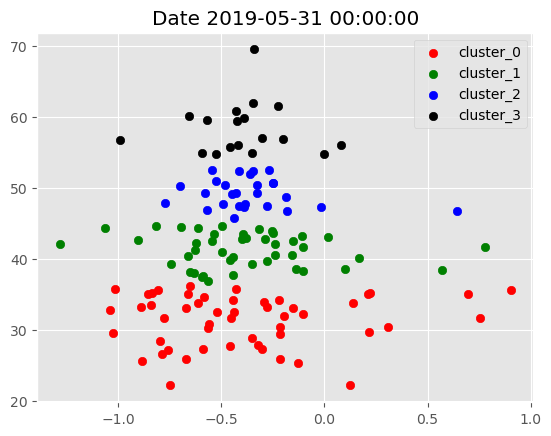

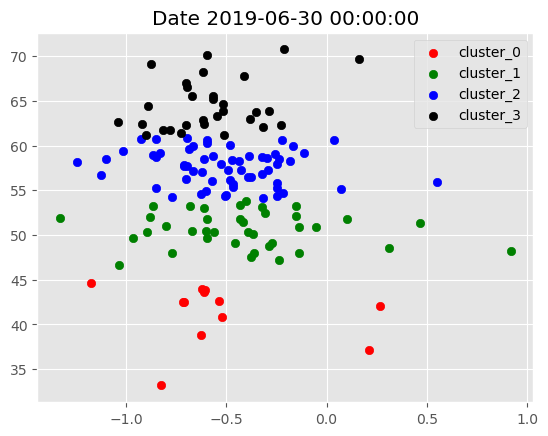

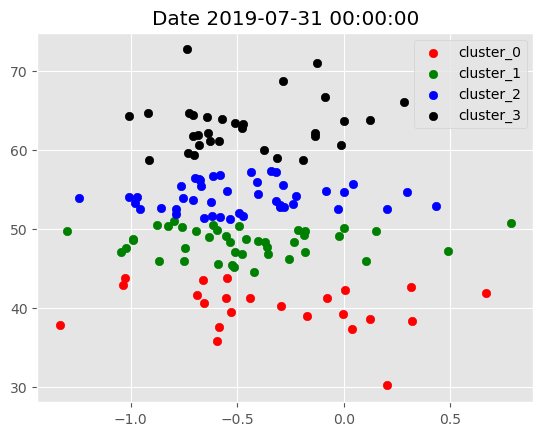

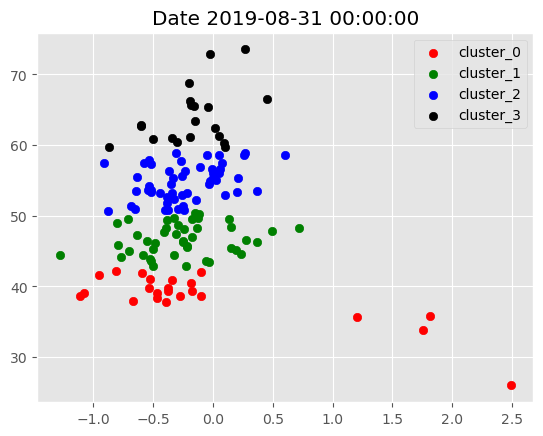

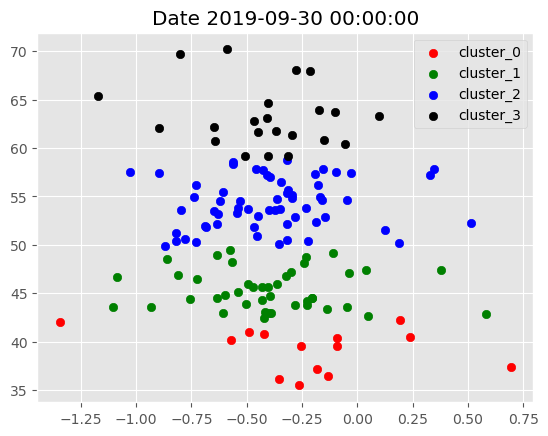

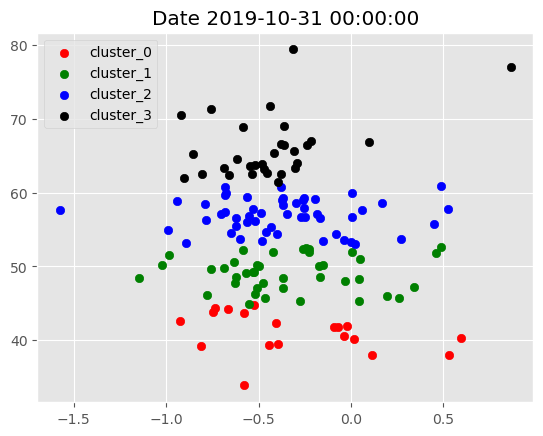

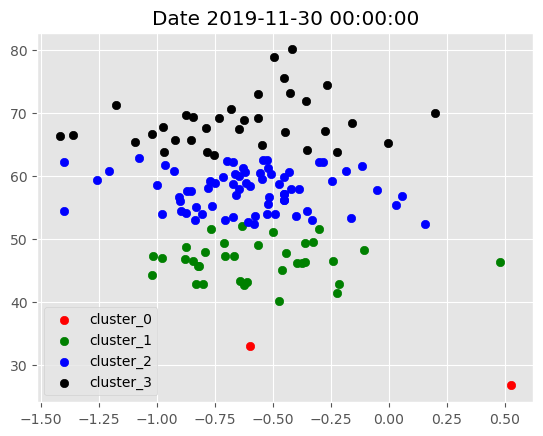

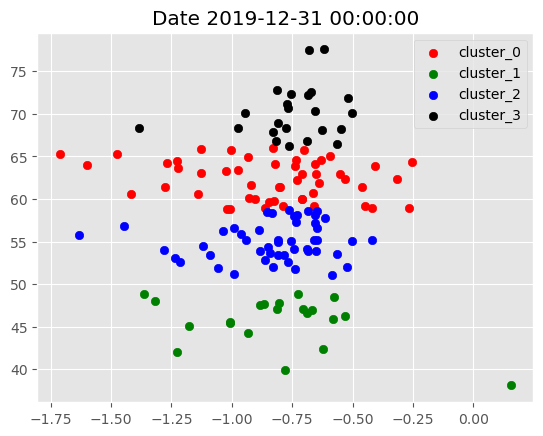

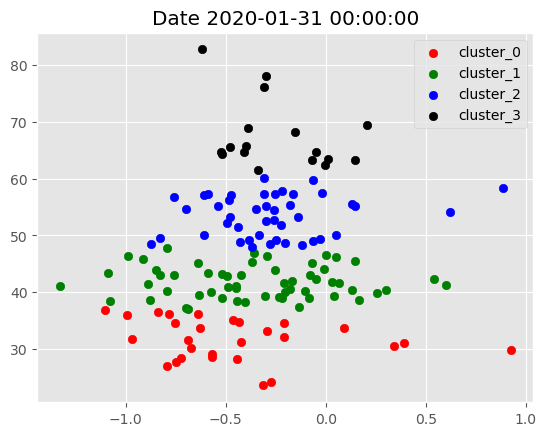

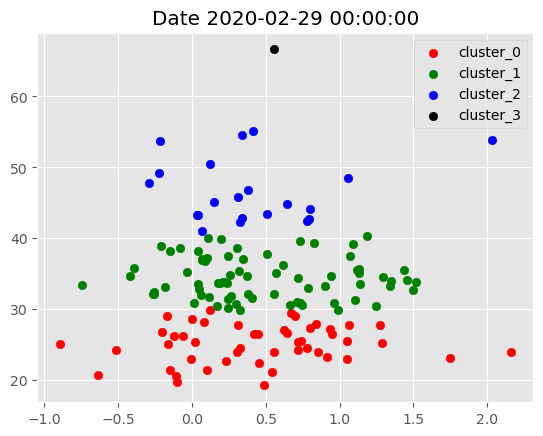

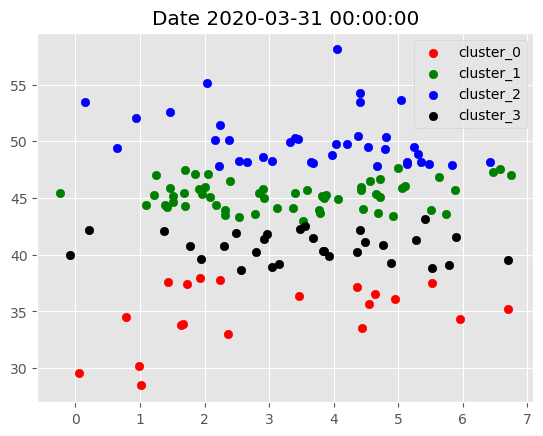

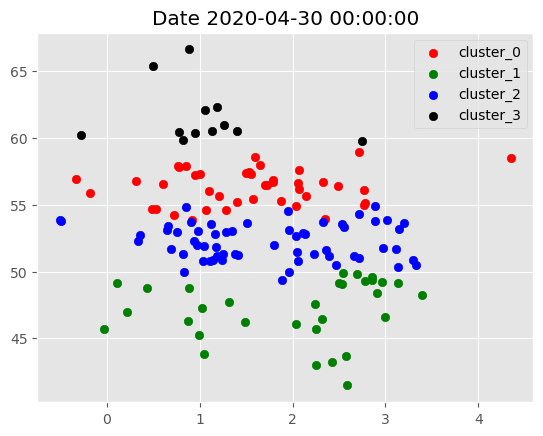

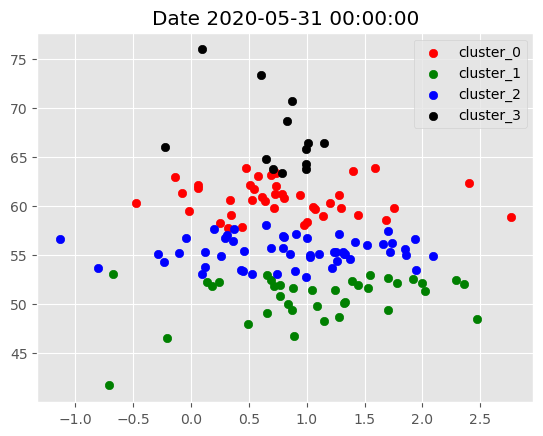

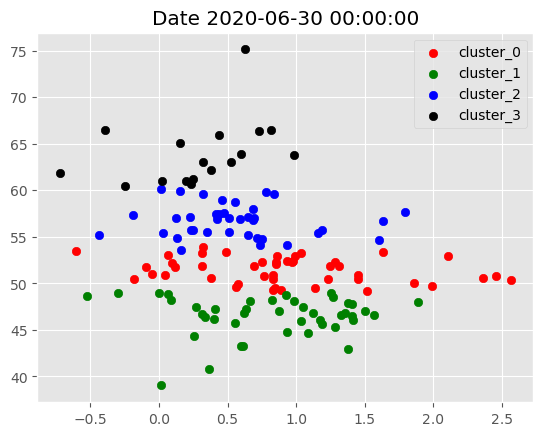

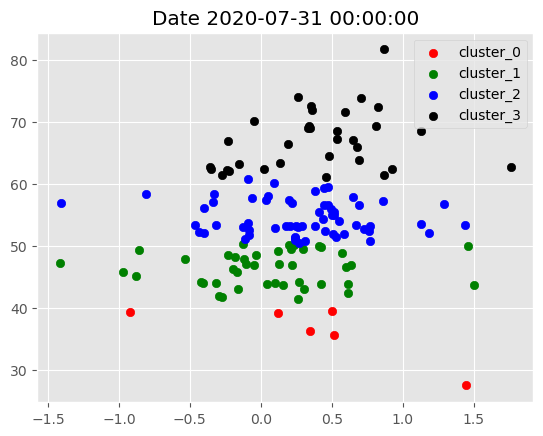

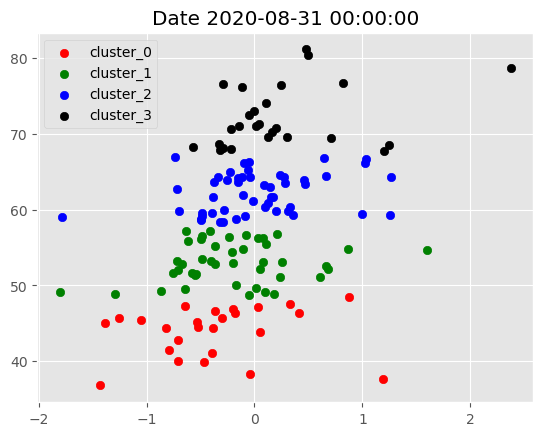

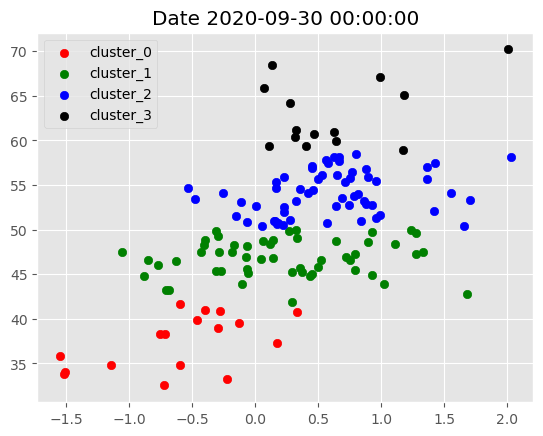

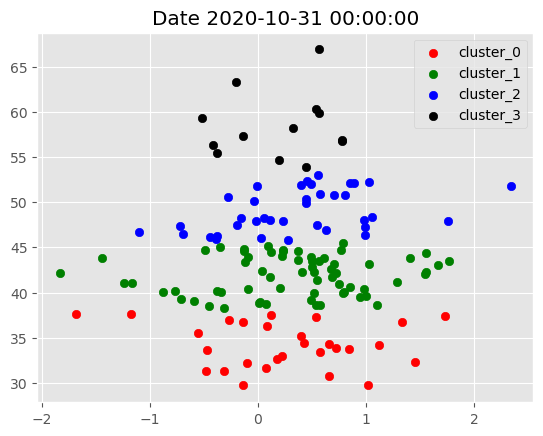

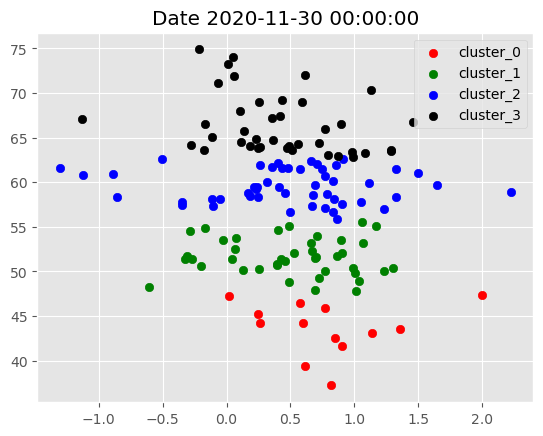

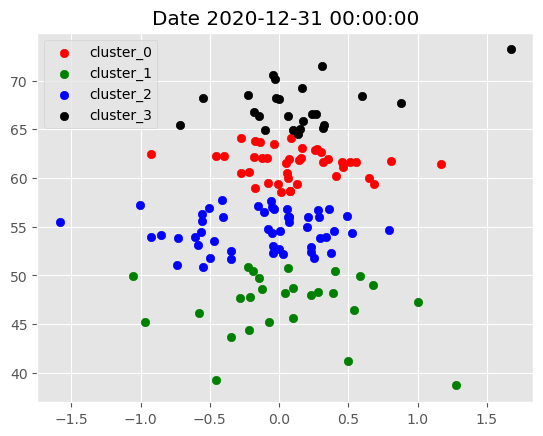

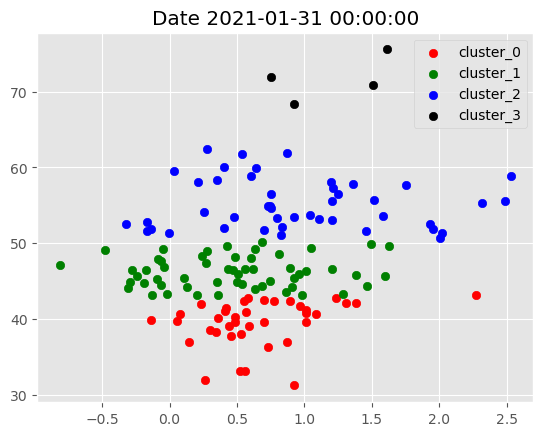

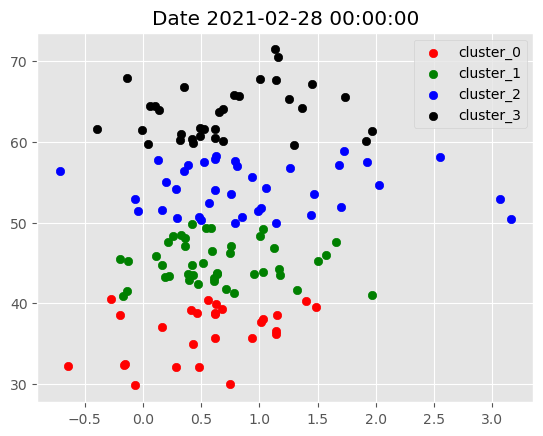

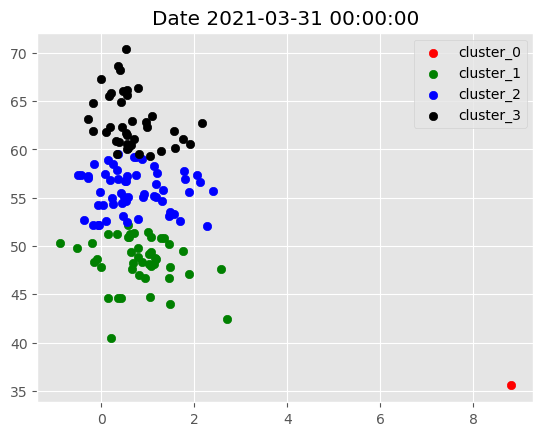

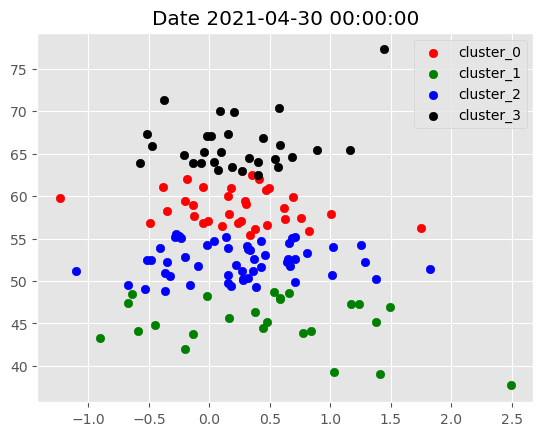

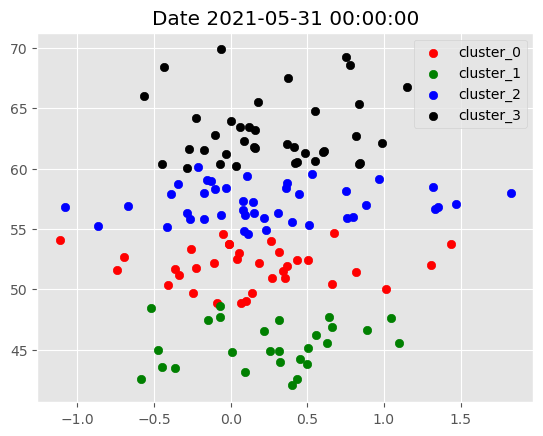

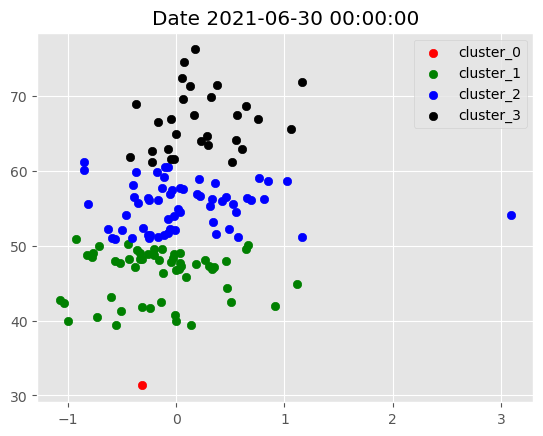

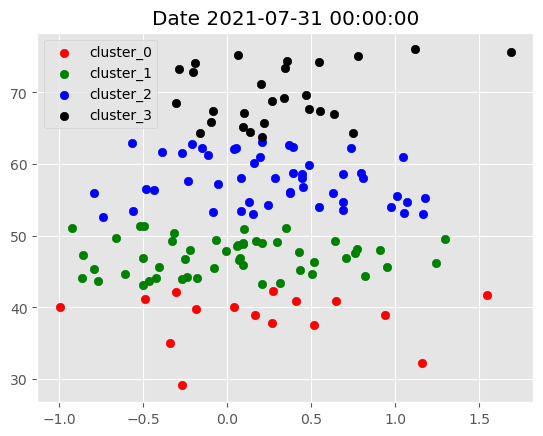

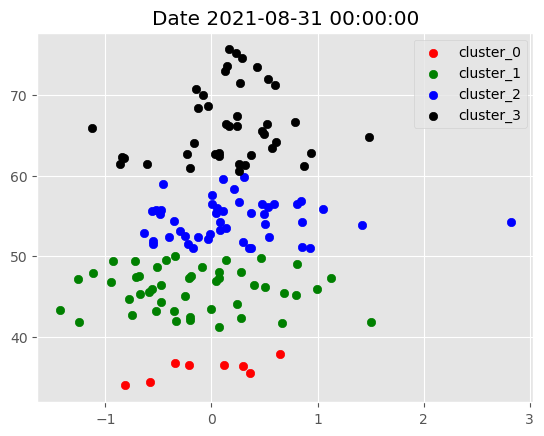

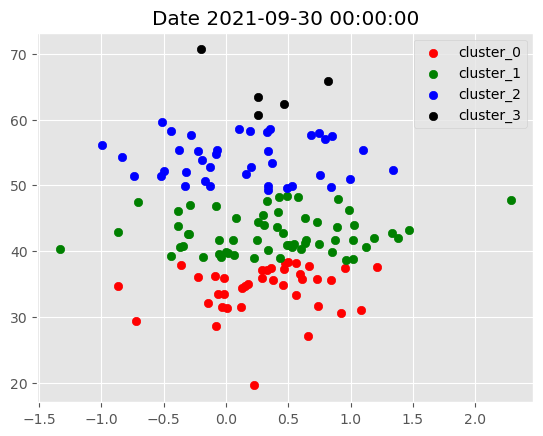

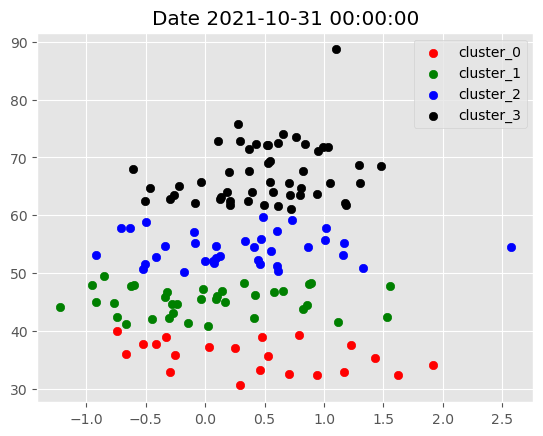

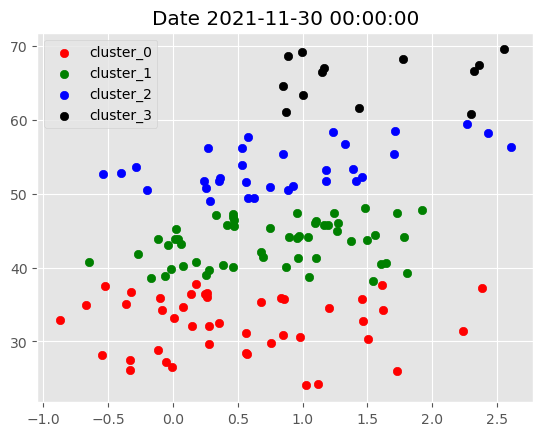

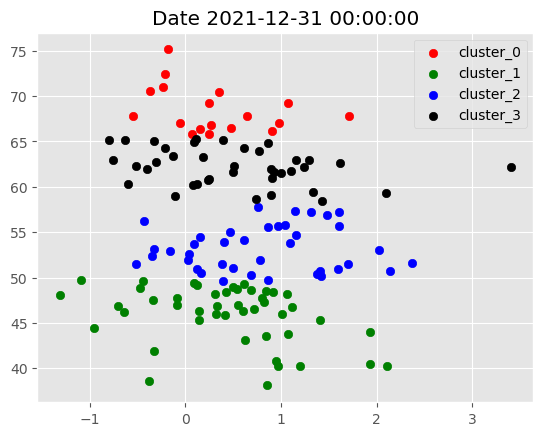

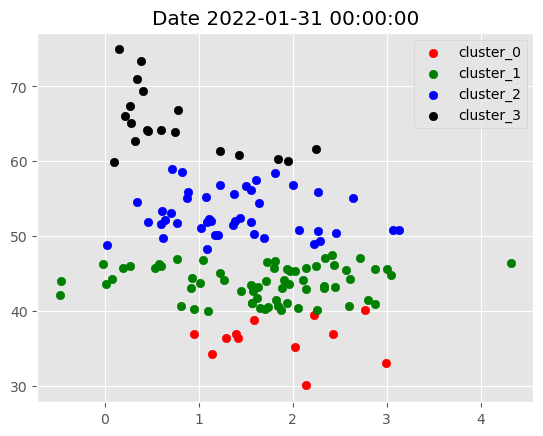

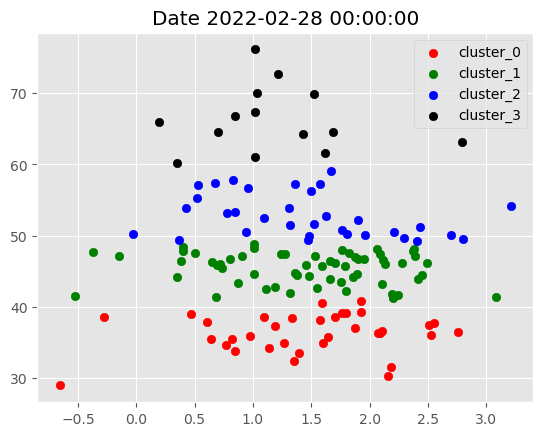

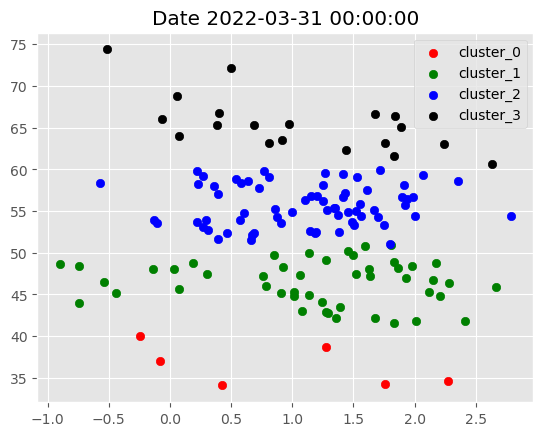

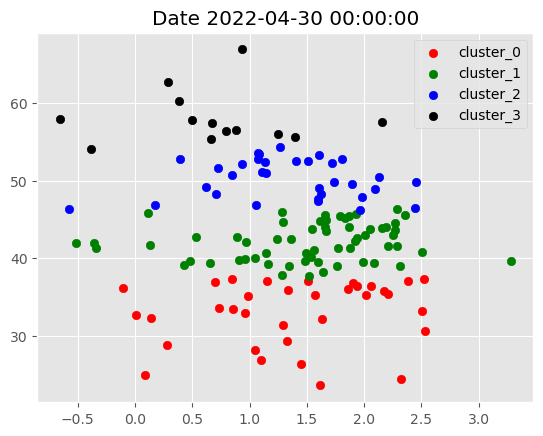

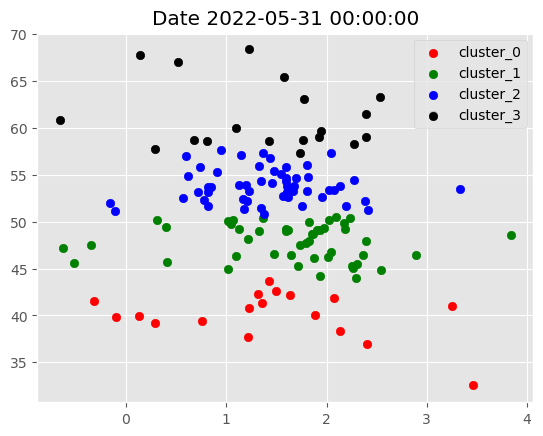

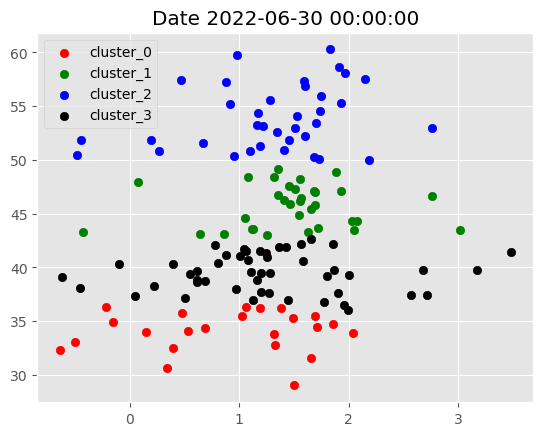

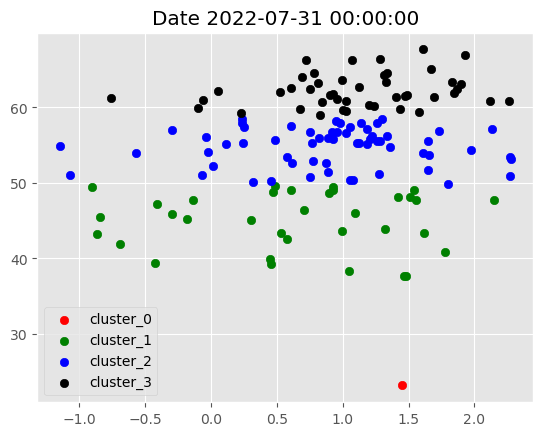

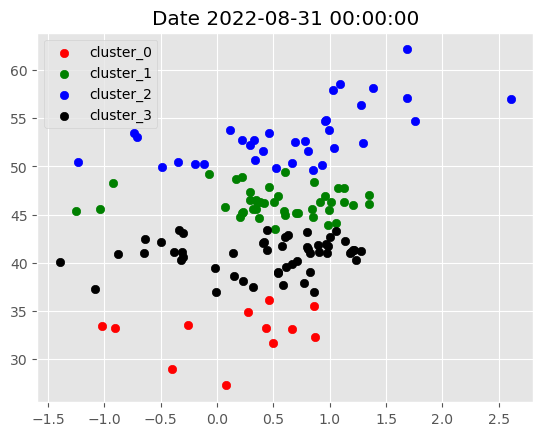

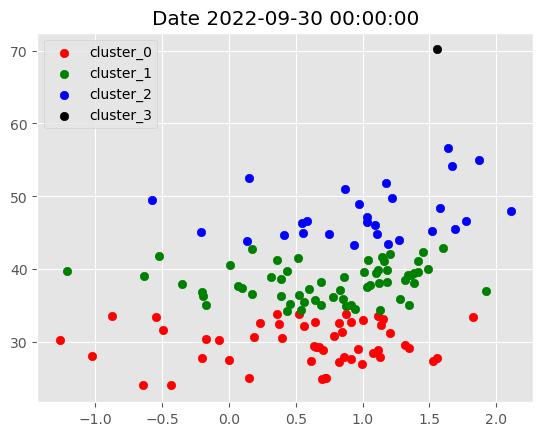

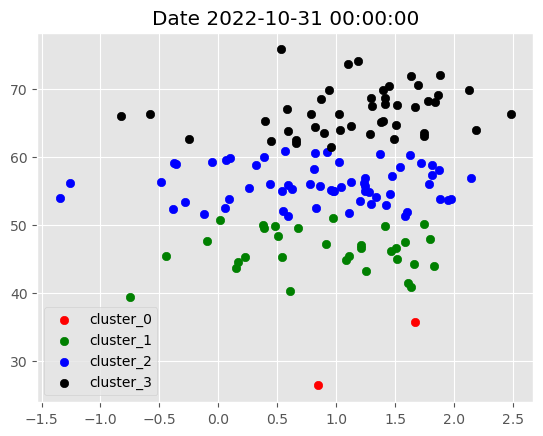

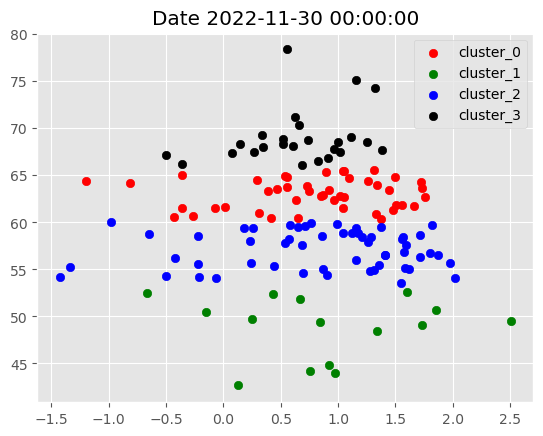

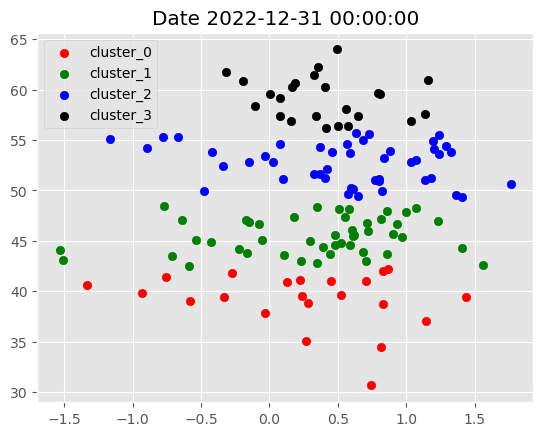

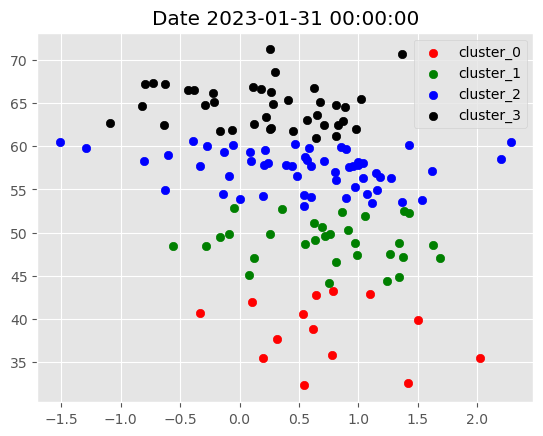

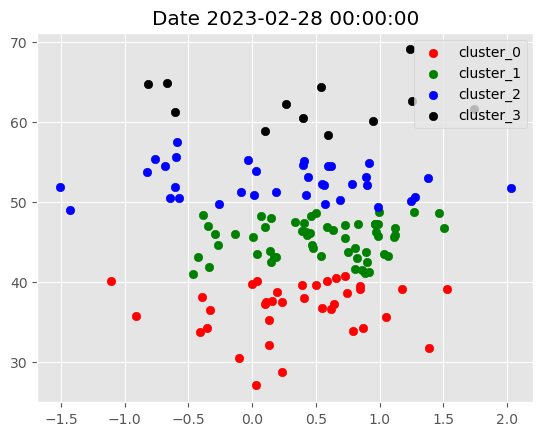

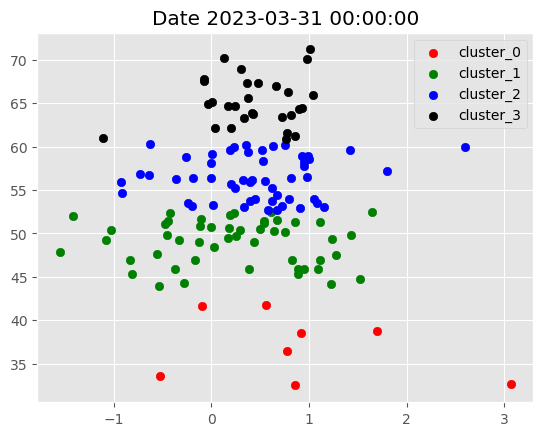

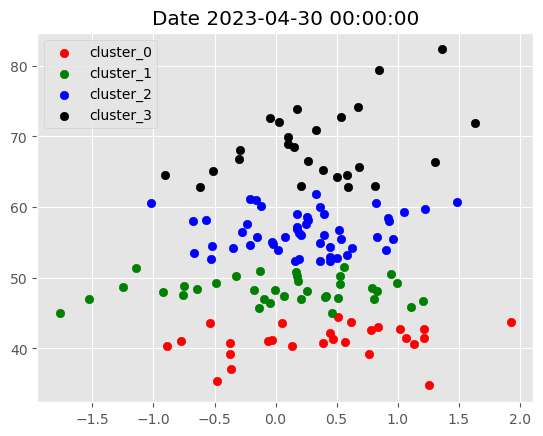

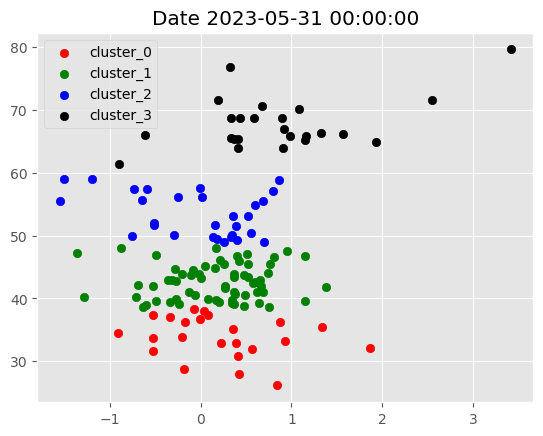

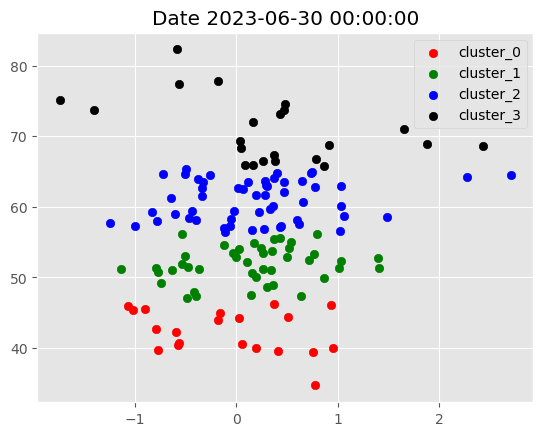

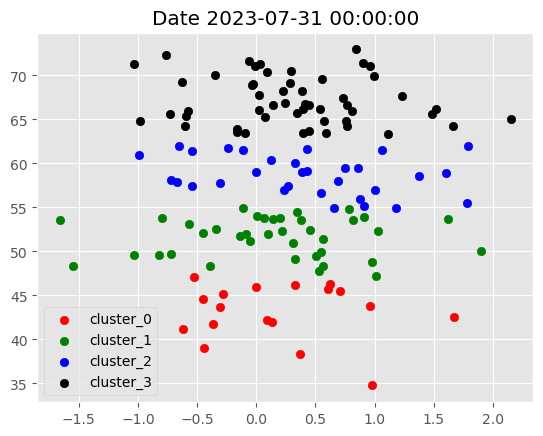

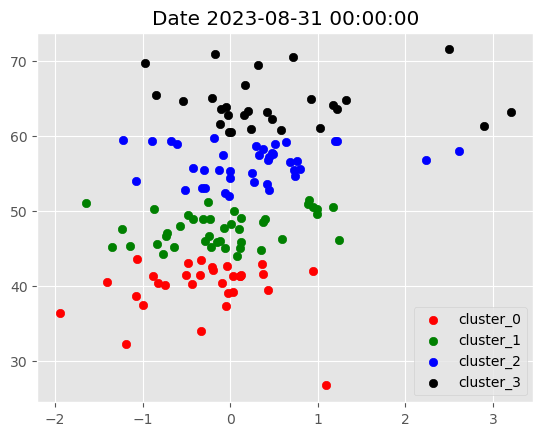

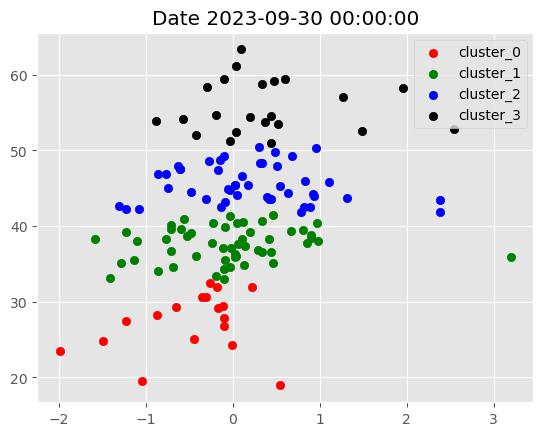

In [106]:
# instead of letting the Kmeans algorithm determine the centroids, we are going to predefine them using our own set of RSI values
# you can see the cluster labels are not consistent month to month
# the RSIs will help us pick the strongest performing stocks
target_rsi_values=[30,45,55,70]
initial_centroids=np.zeros((len(target_rsi_values),18)) # there are 18 features
initial_centroids[:,1]=target_rsi_values

# rerun the clustering
data=data.drop('cluster',axis=1)

def get_clusters(df):
    df['cluster']=KMeans(n_clusters=4,
                        random_state=0, # ensure results are the same each run
                        init=initial_centroids).fit(df).labels_ # initialize Kmeans class, fit it to the data, and get the labels of each point
    return df

data=data.dropna().groupby('date',group_keys=False).apply(get_clusters) # clean data and group by dates

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g=data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

 


# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis
- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - this I would select corresponding stocks in cluster 3

In [107]:
filtered_df=data[data['cluster']==3].copy() # get the list of stocks at the end of the month that we want to invest in in the following month
filtered_df=filtered_df.reset_index(level=1) # reset to index (why?)
filtered_df.index=filtered_df.index+pd.DateOffset(1) # add 1 day to the date to push to the first day of the next month
filtered_df=filtered_df.reset_index().set_index(['date','ticker']) # reset to multi-index 
dates=filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates={} # initialize the dictionary of stocks for a given month
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')]=filtered_df.xs(d,level=0).index.tolist() # add the chosen tickers to each month. xs is a dataframe slicer for frames with multi-indices
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['

### Define the portfolio optimization function
- We will define a function which optimizes the portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
- To optimized the weights of a given portfolio we would need to supply last 1 year prices to the function.
- Apply single stock weight bounds constraint for diversification (minimum half of equal weight and maximum 10% of portfolio)

In [108]:
# import portfolio optimization routines from PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# construct optimal investement weights for each stock
def optimize_weights(prices,lower_bound=0):
    returns=expected_returns.mean_historical_return(prices=prices,frequency=252) # calculate the expected return of each stock from historical mean, 252 trading days in a given year

    cov=risk_models.sample_cov(prices=prices,frequency=252) # calculate the covaraince of each stock

    eff=EfficientFrontier(expected_returns=returns,
                          cov_matrix=cov,
                          weight_bounds=(lower_bound,.1), # set the minimum and maximum weight a single stock can take. 0 is none and 1 is everything
                          solver='SCS')
    
    weights=eff.max_sharpe()

    return eff.clean_weights()

- Need to download day to day pricing data for each stock
- need to get data starting from a year prior than we got before

In [109]:
stocks=data.index.get_level_values('ticker').unique().tolist()

new_df=yf.download(tickers=stocks,
                   start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                   end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  154 of 154 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.248028   40.620983  34.463543  103.970642   
2016-11-01  38.363213   25.774115   41.108887  34.296665  103.881195   
2016-11-02  38.276459   25.797228   41.356495  33.989262  106.090492   
2016-11-03  38.054211   25.520714   40.701073  33.708210  104.605713   
2016-11-04  38.402084   25.290672   40.810318  34.331795  104.856178   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.624222  151.668289  96.467384  314.532135   
2023-09-26  12.700000  171.514893  150.942551  95.240135  308.201630   
2023-09-27  12.610000  169.988831  150.177597  94.547333  311.942383   
2023-09-28  12.920000  170.248184  149.314560  97.110695  298.437927   
2023-09-29  12.810000  170.766830  146.186050  95.853752  304.728760   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   74.686066   72.279999  50.977711   26.700005  ...   
2016-11-01  106.870003   74.565964   70.099998  50.134968   26.534739  ...   
2016-11-02  105.889999   77.191055   68.680000  50.027557   26.250114  ...   
2016-11-03  107.169998   76.633415   67.610001  48.044640   25.956303  ...   
2016-11-04  106.199997   76.418976   69.440002  47.408443   25.910389  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  238.573792  205.669998  61.795918  136.297150  ...   
2023-09-26  506.299988  235.810547  201.660004  60.930592  133.792526  ...   
2023-09-27  502.600006  241.168076  202.279999  60.681938  134.770416  ...   
2023-09-28  504.670013  241.843964  207.889999  60.950485  137.923645  ...   
2023-09-29  509.899994  239.130417  206.910004  60.274143  138.153152  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                   
Ticker          WMT     WYNN       XOM  
Date                                    
2016-10-31  6389000  1341600  16663800  
2016-11-01  8838600  3722300  13050600  
2016-11-02  7645300  2542400  11226100  
2016-11-03  6803900  9050400   8836500  
2016-11-04  7262100  3223800  13877100  
...             ...      ...       ...  
2023-09-25  3486500  1387800  11316000  
2023-09-26  4811900  1454000  11805400  
2023-09-27  5237000  2050000  23976200  
2023-09-28  3872400  1290400  16808100  
2023-09-29  6279300  1326800  18810700  

[1740 rows x 924 columns]

- Calculate the daily returns for each stock which could end up in our portfolio.
- Then loop over each month start, select the stocks for each month and calculate their weights for the next month.
- If the maximum sharpe ratio optimization fails for a given month, appply equally-weighted weights.
- Calculate each day portfolio return.

In [173]:
returns_df=np.log(new_df['Adj Close']).diff()
#returns_df

portfolio_df=pd.DataFrame()

for start_date in fixed_dates.keys(): # grab the start date of each month
    try:
        end_date=(pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d') # grab the end date of each month
        cols=fixed_dates[start_date] # get the tickers for that month
        optimization_start_date=(pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d') # set the opt start date 1 year previous
        optimization_end_date=(pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d') # set the opt end date 1 day prior to the current 'start_date' variable
        optimization_df=new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols] # build a new DF to hold the daily 'Adj Close' for the selected tickers for each set of opt dates
        
        
        success=False

        try:
        # # calculate the weights
            weights=optimize_weights(prices=optimization_df,
                                lower_bound=round(1/(len(optimization_df.columns)*2),3)) # round the lower bound to 3 places based on the number of tickers in each month
            weights=pd.DataFrame(weights,index=pd.Series(0)) # make into a DF, not sure why index is set to a Series (sets every index to '0'??)
            success=True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights=pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                index=optimization_df.columns.tolist(),
                                columns=pd.Series(0)).T
            
        # # need to merge the returns and weights DFs
        temp_df=returns_df[start_date:end_date]

        # the following statement is slightly modified from the original (below it) because yfinance now adds 'Ticker' column label to the DF
        # so you have to rename the column to index. Before the column got named 'index' during one of the stacking operations I think.
        # reseting the index to 'Date' and 'index' allows the following commands to work, otherwise an error is thrown about (un)stacking duplicates
        temp_df=temp_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                                                                left_index=True,
                                                                right_index=True).reset_index().rename(columns={'Ticker':'index'}).set_index(['Date','index']).unstack().stack()
        #temp_df=temp_df.stack().to_frame('return').reset_index(level=0)\
            #                                        .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
            #                                          left_index=True,
            #                                         right_index=True).reset_index().set_index(['Date','index']).unstack().stack()
        #temp_df.index.names=['date','ticker']
        temp_df['weighted_return']=temp_df['return']*temp_df['weight'] # calculate weighted return of each individual stock
        temp_df2=temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return') # calculate the daily return total

        portfolio_df=pd.concat([portfolio_df,temp_df2],axis=0) # concat summed return DF to portfolio DF
    except Exception as e:
        print(e)

portfolio_df=portfolio_df.drop_duplicates()
portfolio_df


Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


Strategy Return
Date                       
2017-11-01         0.001361
2017-11-02         0.002909
2017-11-03         0.006310
2017-11-06         0.003008
2017-11-07         0.002704
...                     ...
2023-09-25         0.003641
2023-09-26        -0.011470
2023-09-27         0.005189
2023-09-28         0.007977
2023-09-29        -0.007698

[1487 rows x 1 columns]

<Axes: xlabel='Date'>

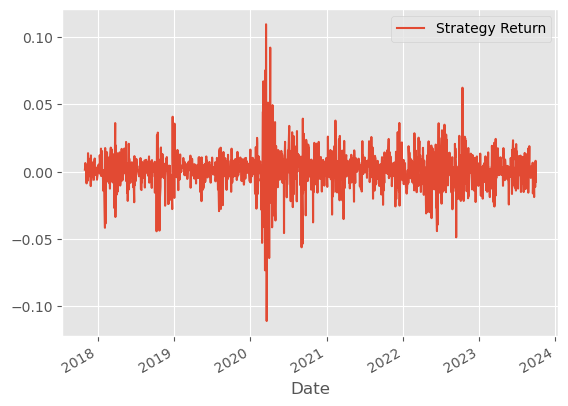

In [174]:
portfolio_df.plot()

# 8. Visualize Portfolio returns and compare to SP500

In [175]:
spy=yf.download(tickers='SPY',
                start='2015-01-01',
                end=dt.date.today())


[*********************100%%**********************]  1 of 1 completed


In [179]:
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df2 = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df2

Strategy Return  SPY Buy&Hold
Date                                     
2017-11-01         0.001361      0.001321
2017-11-02         0.002909      0.000388
2017-11-03         0.006310      0.003333
2017-11-06         0.003008      0.001547
2017-11-07         0.002704     -0.000696
...                     ...           ...
2023-09-25         0.003641      0.004196
2023-09-26        -0.011470     -0.014800
2023-09-27         0.005189      0.000399
2023-09-28         0.007977      0.005781
2023-09-29        -0.007698     -0.002430

[1487 rows x 2 columns]

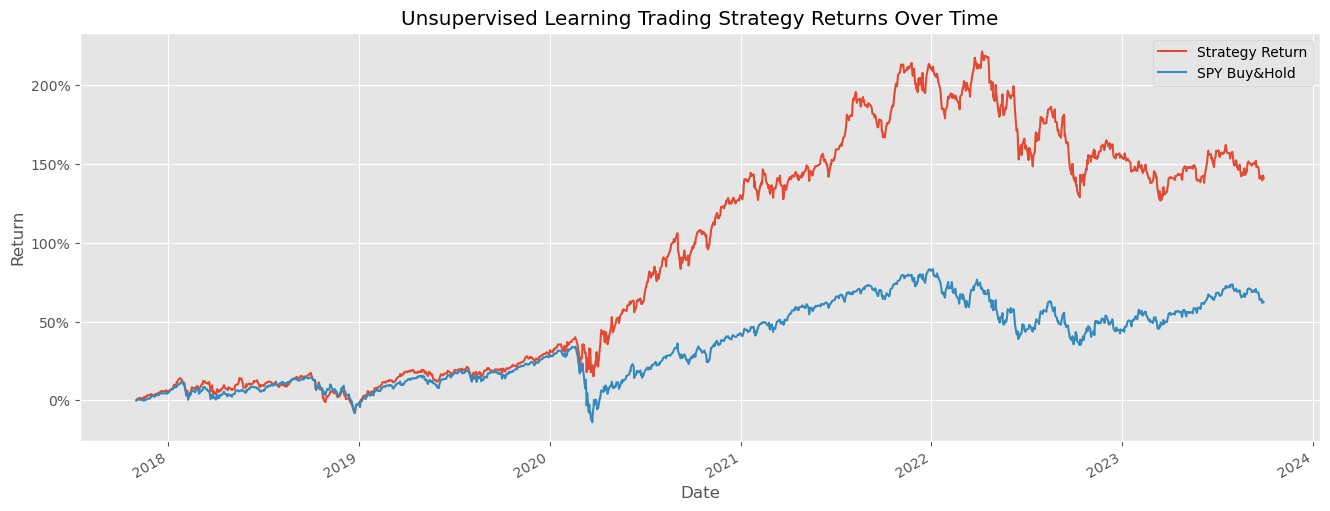

In [182]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')

portfolio_cumulative_return=np.exp(np.log1p(portfolio_df2).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()